# **DOMAIN´S CLUSTERING**

- In this notebook I´m going to try and test different clustering models, preprocessing the data in different ways to compare and choose the best results, that is, to find different clusters with similar charasteristics or properties, with the objective of make the advertiser decision of where are the optimal domains to invest easier

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import manhattan_distances


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

#! pip install pyclustertend

In [5]:
groupby_domains = pd.read_csv('Global groupby_domains.csv')

In [6]:
groupby_domains.head(1)

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category,Category importance,Domain Recurrence
0,memurlar.net,2849893.77,9517.08,0.72,83.57,91.96,1.58,48.92,0.49,66.98,Health & Wellness,2.08,33.45


### IMPORTANT: 
**The proccess that is detailed below has been done with different combinations of variables**.

- First I considered all the variables at once, applying different data preproccesings 
- Second I tested the clustering algorithms several times selecting different combinations of variables, between 6 and 9
- Finally I did that comes next, wich has turned out to be the best choice

****In order to get a better clustering performance, I´m gonna drop the following columns :****

- **Domain:** it´s a string and doesn´t add nothing to the model
- **Category:** I could convert the Categories into numbers, but this can strongly affect to the model, and the categories are also represented in the Category importance columns
- **Viewability Rate, Efficiency Rate:** these columns are important to the advertisers (that´s the reason I didn´t drop them in the first place) but both of them have really high percentages for most of Domains, so they are not useful to find differences between them
- **Clicks**: It has a strong correlation with the Impressions variable, and it´s represented in the CTR (Clicks/Impressions)

- **'Format Loads', 'Impressions'**: ***After repeating this whole proccess with different variables, I decided to keep for this clustering only the variables represented by percentages, in order to have the date with similar scales. It has proven that if I take the Format Loads and Impressions variable, the models are distorted because of it´s large scale, although I applied transformation to the data as MinMax, Standard or Robust scalers***

I´m gonna test the clustering over three different data transformations :

- **Standarizing the data with Standard Scaler**
- **Scaling features using statistics that are robust to outliers with Robust Scaler**
- **Transforming features by scaling each feature to a given range (0,1) with MinMax Scaler**

In [8]:
groupby_domains_clustering = groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks','Category',
                                                   'Viewability Rate', 'Efficiency Rate'], 1)
groupby_domains_StandardScaler = StandardScaler().fit_transform(groupby_domains_clustering)
groupby_domains_RobustScaler = RobustScaler().fit_transform(groupby_domains_clustering)
minmax = MinMaxScaler().fit_transform(groupby_domains_clustering)

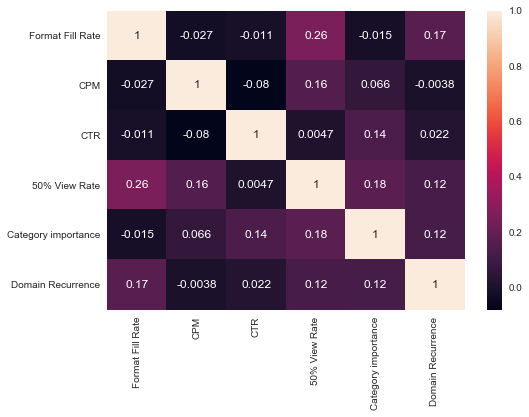

In [8]:
sns.heatmap(groupby_domains_clustering.corr(), annot=True)

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002972585DA48>,
       dtype=object),)

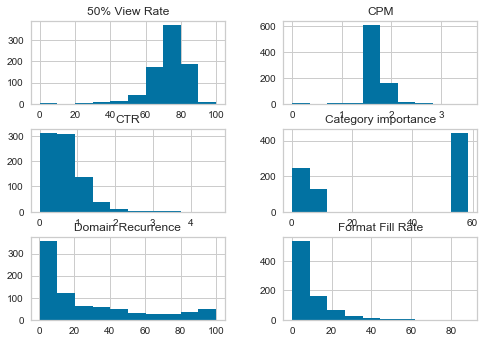

In [280]:
groupby_domains_clustering.hist(),

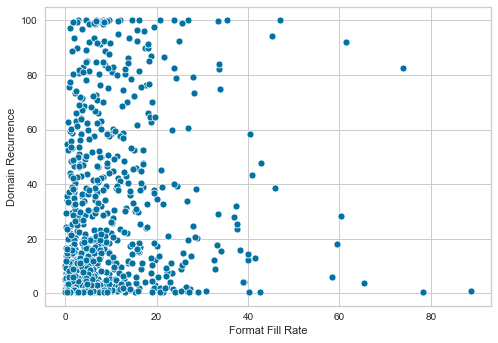

In [11]:
sns.scatterplot(groupby_domains_clustering['Format Fill Rate'], groupby_domains_clustering['Domain Recurrence'])

### Visual Assessment of cluster Tendency (VAT)

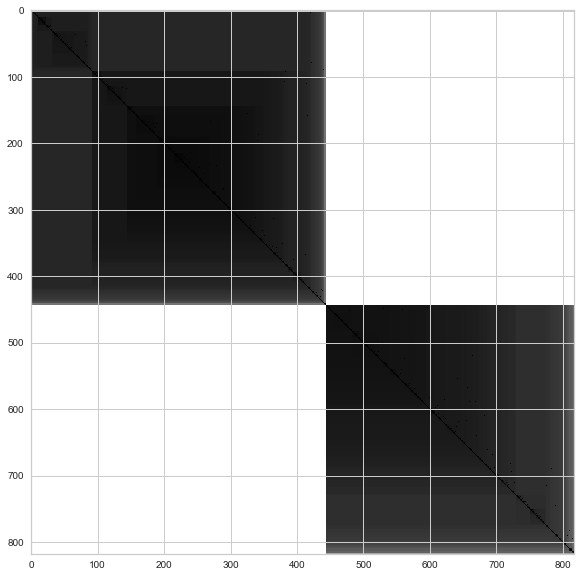

In [154]:
from pyclustertend import ivat
ivat(groupby_domains_clustering)

## Applying GRIDSEARCHCV to find the best parameters for KMEANS ALGORITHM

- ### With the Standard Scaler transformation:

In [8]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,15),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,500,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_standardscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [10]:
%%time
gridsearchcv_standardscaler.fit(groupby_domains_StandardScaler)

Wall time: 42min 47s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 500, 700, 1000],
                         'n_clusters': range(1, 15),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
#Saving the results in a DataFrame
gridsearch_results_SS = pd.DataFrame(gridsearchcv_standardscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_SS.to_csv('GridSearch Standard Scaler Results.csv')
gridsearch_results_SS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3145,0.04,0.00,0.00,0.00,elkan,random,400,14,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-1817.66,-527.36,-547.53,-402.67,-441.44,-747.33,537.82,1
1815,0.08,0.01,0.00,0.00,full,random,100,14,5,"{'algorithm': 'full', 'init': 'random', 'max_i...",-2077.53,-493.75,-527.52,-408.41,-485.67,-798.58,640.67,2
3146,0.10,0.00,0.00,0.00,elkan,random,400,14,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-2102.65,-454.43,-534.86,-390.99,-510.29,-798.64,653.88,3


In [13]:
# save the model to disk
filename = 'gridsearchmodel_standardscaler.sav'
pickle.dump(gridsearchcv_standardscaler, open(filename, 'wb'))

In [14]:
# load the model from disk
filename = 'gridsearchmodel_standardscaler.sav'
gridsearchmodel_standardscaler = pickle.load(open(filename, 'rb'))


In [15]:
gridsearchmodel_standardscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=400,
       n_clusters=14, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- ### With the Robust Scaler transformation:

In [16]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,17),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_robustscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [17]:
%%time
gridsearchcv_robustscaler.fit(groupby_domains_RobustScaler)

Wall time: 51min 34s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 700, 1000],
                         'n_clusters': range(1, 17),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
#Saving the results in a DataFrame
gridsearch_results_RS = pd.DataFrame(gridsearchcv_robustscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_RS.to_csv('GridSearch Results with Robust Scaler.csv')
gridsearch_results_RS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3356,0.12,0.02,0.00,0.00,elkan,random,1000,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5372.63,-686.85,-633.02,-462.59,-555.98,-1542.21,1916.70,1
2956,0.19,0.02,0.00,0.00,elkan,random,100,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5341.84,-697.44,-665.97,-512.00,-543.19,-1552.09,1896.18,2
1039,0.38,0.04,0.00,0.00,auto,random,700,16,25,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-5346.14,-675.65,-684.13,-519.91,-557.82,-1556.73,1895.79,3


In [20]:
# save the model to disk
filename = 'gridsearchmodel_robustscaler.sav'
pickle.dump(gridsearchcv_robustscaler, open(filename, 'wb'))

In [21]:
# load the model from disk
filename = 'gridsearchmodel_robustscaler.sav'
gridsearchmodel_robustscaler = pickle.load(open(filename, 'rb'))


In [22]:
gridsearchmodel_robustscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=1000,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- ### With the MinMax Scaler transformation:

In [16]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,17),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_robustscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [17]:
%%time
gridsearchcv_minmax.fit(minmax)

Wall time: 51min 34s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 700, 1000],
                         'n_clusters': range(1, 17),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
#Saving the results in a DataFrame
gridsearch_results_MM = pd.DataFrame(gridsearchcv_minmax.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_MM.to_csv('GridSearch Results with MinMax Scaler.csv')
gridsearch_results_MM.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3356,0.12,0.02,0.00,0.00,elkan,random,1000,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5372.63,-686.85,-633.02,-462.59,-555.98,-1542.21,1916.70,1
2956,0.19,0.02,0.00,0.00,elkan,random,100,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5341.84,-697.44,-665.97,-512.00,-543.19,-1552.09,1896.18,2
1039,0.38,0.04,0.00,0.00,auto,random,700,16,25,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-5346.14,-675.65,-684.13,-519.91,-557.82,-1556.73,1895.79,3


In [20]:
# save the model to disk
filename = 'gridsearchmodel_robustscaler.sav'
pickle.dump(gridsearchcv_robustscaler, open(filename, 'wb'))

In [21]:
# load the model from disk
filename = 'gridsearchmodel_robustscaler.sav'
gridsearchmodel_robustscaler = pickle.load(open(filename, 'rb'))


In [22]:
gridsearchmodel_robustscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=1000,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

**I decide not to choose the random init, although it has been chosen as the best init parameter in both scenarios. In some cases, if the initialization of clusters is not appropriate, K-Means can result in arbitrarily bad clusters. This is where K-Means++ helps, because it specifies a procedure to initialize the cluster centers before moving forward with the standard k-means clustering algorithm**

**Using the K-Means++ algorithm, we optimize the step where we randomly pick the cluster centroid, and we are more likely to find a solution that is competitive to the optimal K-Means solution while using the K-Means++ initialization**

Because of that, I´ll choose the best result where with the k-means++ init:

In [19]:
gridsearch_results_RS = pd.read_csv("GridSearch Results with Robust Scaler.csv")
gridsearch_results_SS = pd.read_csv("GridSearch Standard Scaler Results.csv")
display(gridsearch_results_RS[gridsearch_results_RS['param_init']=='k-means++'].head(1))
display(gridsearch_results_RS[gridsearch_results_SS['param_init']=='k-means++'].head(1))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,556,0.16,0.01,0.00,0.00,auto,k-means++,1000,16,10,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",-5363.48,-682.62,-667.99,-592.56,-580.18,-1577.37,1893.49,10


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,3350,0.06,0.00,0.00,0.00,elkan,random,1000,15,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5381.67,-690.97,-703.62,-508.84,-577.82,-1572.59,1905.92,8


# KMEANS ALGORITHM

### ELBOW METHOD visualization to check the ideal number of clusters 

- ### With the Standard Scaler transformation:

In [9]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz and silhouette scores visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)        # Fit the data to the visualizer
    visualizer2.show()        # Finalize and render the figure
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        # Fit the data to the visualizer
    visualizer3.show()        # Finalize and render the figure

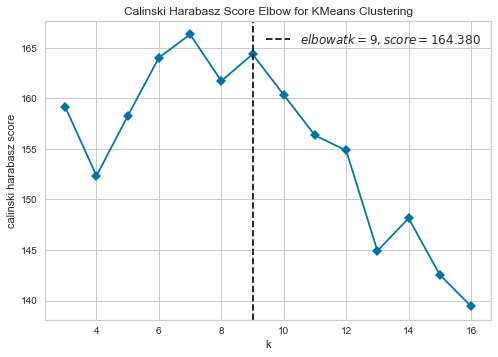

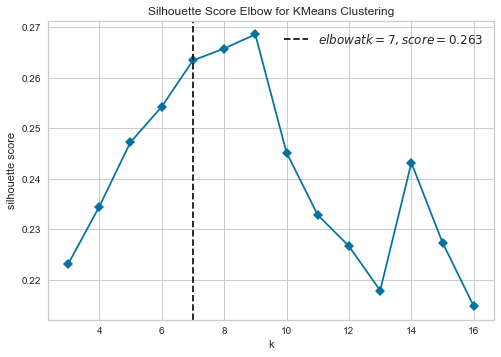

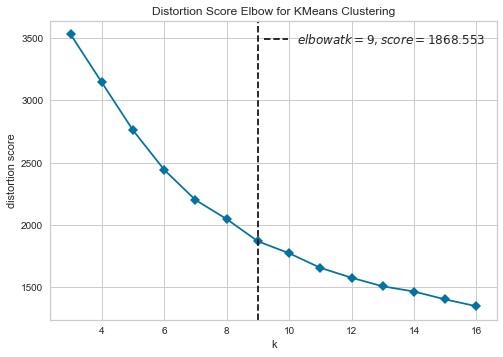

In [13]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the Robust Scaler transformation:

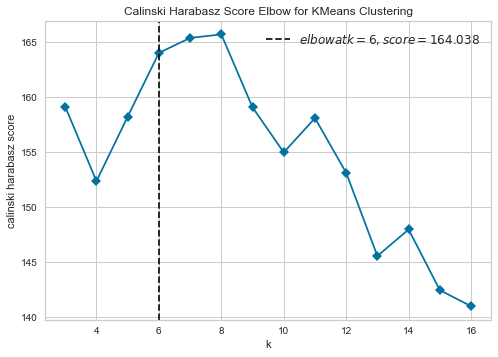

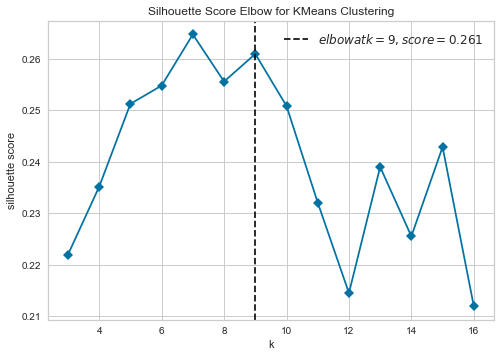

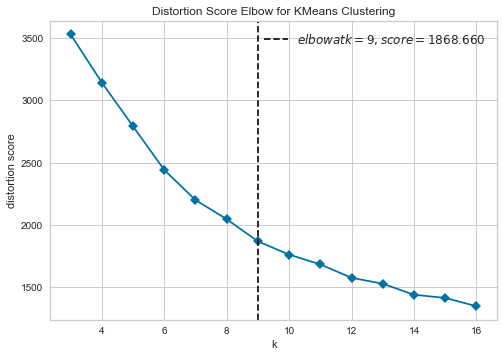

In [18]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the MinMax transformation:

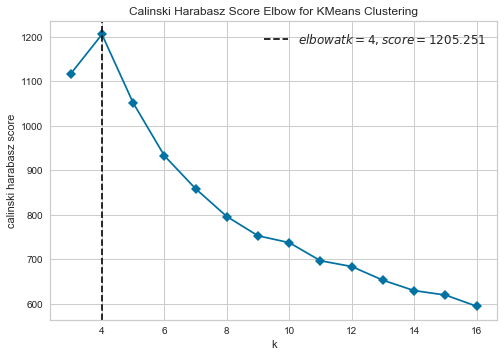

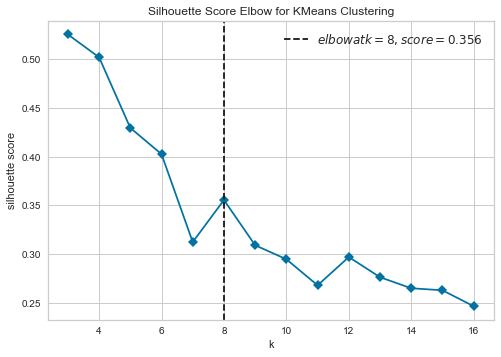

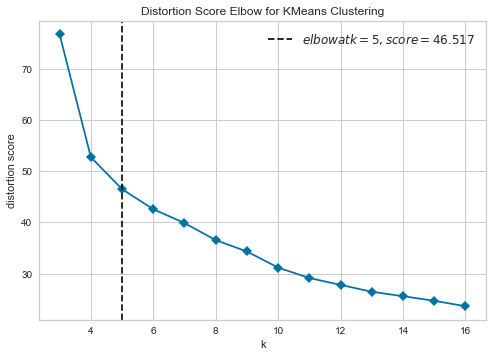

In [15]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(minmax, model)

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


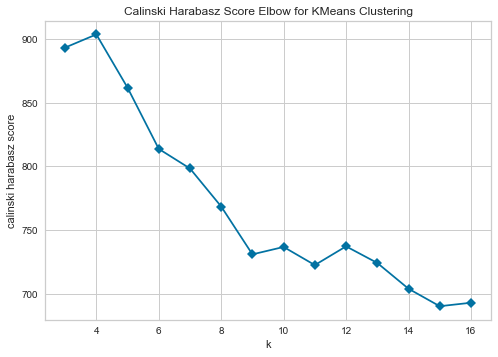

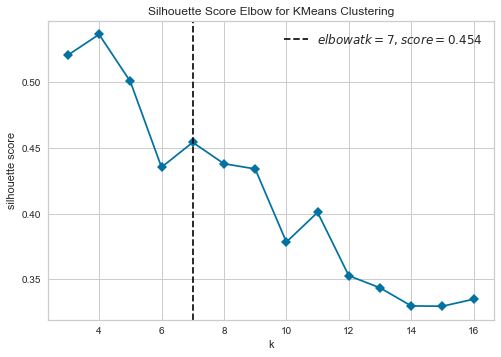

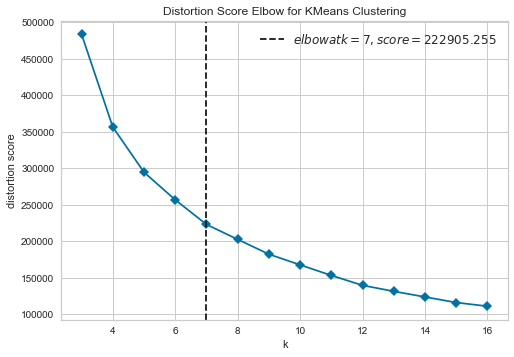

In [136]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_clustering, model)

- **My first impression is that, in order to simplify and make the advertiser decision easier, detecting a specific cluster attending to its preferences, the number of clusters should not be more than 10**

- **The GridSearchCV best result for n_clusters is the maximum I defined (14 in the first case, and 16 in the second case). But attending to the Elbow Method I´m gonna train the Kmeans Model with 9 clusters**

### Training the KMEANS model

In [15]:
def results_evaluation(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))


- ### With the optimal parameters for Standard Scaled Data, based on the GridSearchCV results

In [21]:
kmeans_StandardScaler = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_StandardScaler.fit(groupby_domains_StandardScaler)
results_evaluation(kmeans_StandardScaler, groupby_domains_StandardScaler)


CLUSTERING DIVISION:
 2    250
1    203
3    115
0     69
5     54
4     48
6     46
7     24
8      9
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,232301.88,19141.21,9.80,81.43,97.69,1.67,124.71,0.67,74.13,4.41,71.16
1,173231.54,9582.22,6.99,83.99,96.15,1.66,55.13,0.53,74.62,4.29,10.03
2,188531.97,11258.66,6.47,85.29,97.29,1.69,73.34,0.64,75.24,58.61,15.19
3,261784.90,24668.43,10.00,85.08,97.47,1.69,192.96,0.76,75.95,58.61,75.12
4,166013.06,61840.14,40.41,86.36,99.27,1.69,277.74,0.50,80.99,28.08,29.70
5,129397.53,7182.78,6.15,87.33,96.72,1.60,148.30,2.00,68.90,38.23,12.13
6,175994.43,3667.55,2.67,69.74,93.73,1.79,14.10,0.35,47.17,13.94,12.57
7,144663.39,3340.87,3.00,83.20,96.83,2.49,20.54,0.41,72.62,38.04,3.97
8,114131.67,1296.13,1.74,40.48,38.71,0.41,6.67,0.11,30.40,9.10,1.21


The Silhouette Score is:  0.2684364708879687
The Calinski Harabasz Score is:  164.48829614271733
The Davies Douldin Score is:  1.104134591030099


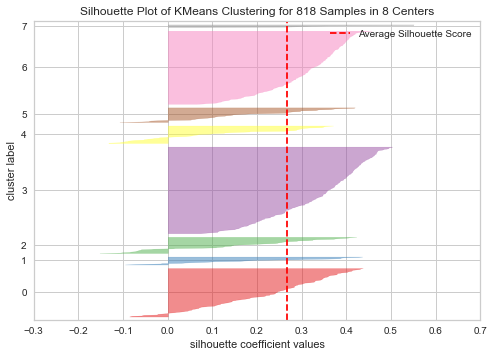

In [25]:
sv = SilhouetteVisualizer(kmeans_StandardScaler)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the optimal parameters for Robust Scaled Data, based on the GridSearchCV results

In [22]:
kmeans_RobustScaler = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_RobustScaler.fit(groupby_domains_RobustScaler)
results_evaluation(kmeans_RobustScaler, groupby_domains_RobustScaler)


CLUSTERING DIVISION:
 6    190
0    162
2    155
5    106
1     80
7     63
8     32
4     21
3      9
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,163960.31,6836.02,4.59,84.69,97.15,1.82,41.08,0.53,76.46,39.84,15.59
1,132662.67,6552.12,5.39,87.18,96.78,1.60,118.92,1.75,69.90,37.31,14.20
2,262353.97,21988.27,8.87,83.25,97.49,1.67,159.51,0.70,75.32,41.14,76.54
3,114131.67,1296.13,1.74,40.48,38.71,0.41,6.67,0.11,30.40,9.10,1.21
4,136361.31,3787.13,3.43,80.29,96.41,2.57,23.07,0.42,69.88,35.10,5.37
5,165023.86,30010.18,20.39,85.69,98.91,1.64,202.75,0.68,76.73,30.51,21.86
6,193762.47,7000.22,4.54,84.85,95.77,1.58,41.27,0.51,74.96,30.88,10.79
7,221843.10,6978.68,3.17,73.20,94.31,1.78,25.54,0.46,51.35,15.63,14.08
8,186571.74,76639.38,46.33,85.68,99.23,1.71,327.64,0.49,81.15,28.01,38.83


The Silhouette Score is:  0.18974857562247172
The Calinski Harabasz Score is:  174.47695769730913
The Davies Douldin Score is:  1.2175064951578873


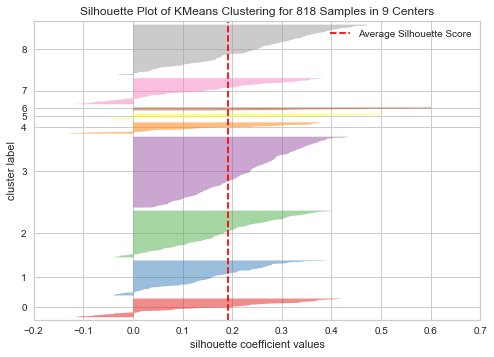

In [20]:
sv = SilhouetteVisualizer(kmeans_RobustScaler)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the MinMax transformation

In [23]:
kmeans_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_minmax.fit(minmax)
results_evaluation(kmeans_minmax, minmax)


CLUSTERING DIVISION:
 0    318
1    292
2    126
3     82
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,175135.87,12161.76,8.05,85.45,97.00,1.71,86.63,0.75,74.25,58.61,13.09
1,165274.86,10699.09,8.15,81.09,94.60,1.67,64.48,0.59,69.65,4.16,9.89
2,261865.95,26234.59,10.74,84.87,97.45,1.69,198.48,0.77,75.80,58.61,73.95
3,232139.74,27281.56,12.81,81.22,97.73,1.67,140.01,0.65,74.40,4.63,70.47


The Silhouette Score is:  0.5028694236654055
The Calinski Harabasz Score is:  1205.2513610986912
The Davies Douldin Score is:  0.7508435358905696


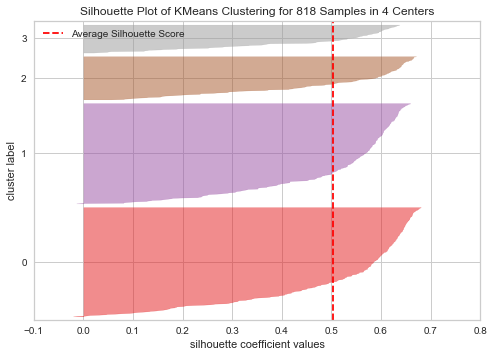

In [28]:
sv = SilhouetteVisualizer(kmeans_minmax)
sv.fit(minmax)
sv.show()

- ### With the raw data

In [138]:
kmeans_raw = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_raw.fit(groupby_domains_clustering)
results_evaluation(kmeans_raw, groupby_domains_clustering)


CLUSTERING DIVISION:
 6    256
5    225
2    110
3     78
1     73
4     55
0     21
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,167017.21,2181.73,1.53,48.53,73.32,1.48,12.27,0.32,31.39,3.37,3.22
1,221051.29,20207.21,13.09,83.56,97.54,1.66,114.18,0.64,72.41,4.14,36.48
2,231242.85,15844.94,8.99,84.34,96.87,1.69,116.63,0.77,74.45,58.61,43.19
3,299492.66,32460.10,11.68,84.17,97.82,1.70,235.32,0.70,75.92,58.61,86.59
4,270155.21,32317.79,13.09,80.40,97.74,1.66,158.40,0.63,75.31,4.58,81.43
5,145747.00,9168.00,7.65,83.54,96.00,1.69,57.79,0.61,72.67,4.31,6.48
6,155824.90,11320.96,7.87,86.04,97.02,1.71,83.48,0.76,74.42,58.61,7.71


The Silhouette Score is:  0.4534392567842015
The Calinski Harabasz Score is:  799.4392664522493


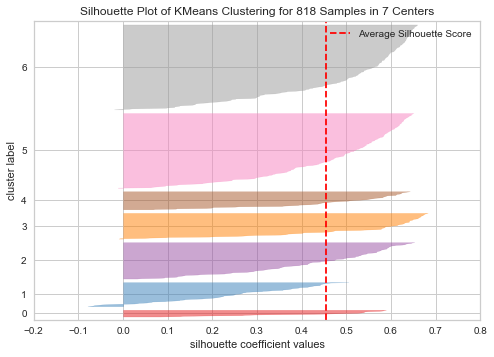

In [139]:
sv = SilhouetteVisualizer(kmeans_raw)
sv.fit(groupby_domains_clustering)
sv.show()

- ### Conclusions:

K-means doesn´t seem to be a good model for this data. The main reasons are:

- In a range bewteen -1 and 1, if the Silhouette Score is close to one, that means clusters are dense and well separated, which relates to a standard concept of a cluster. With Standar Scaler and Robust Scaler data the Silhouette Score is around 0.20. And in the Silhouette Score analysis, we can confirm that we only have a decent score when the number of clusters is 2

- It´s visually difficult to diferenciate the clusters in the graph

- K-Means doesn´t use to work well with large datasets and many features, and it has proven that the eucledian distance metric can be a wrong metric with high dimensions

- Ouliers is clearly a problem in this dataset and Kmeans algorithm is really sensitive to this ouliers, although I´ve applied the Robust Scaler transformation, which minimizes the impact of the outliers 

- According to the evalution metrics (Silhouette Score and Calinski-Harabasz Index) there´s not a big difference between using the data with the Standard Scaler transformation, or the Robust Scaler transformation, but the results highly improved using the MinMaxScaler






## HIERARCHICAL CLUSTERING

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import manhattan_distances


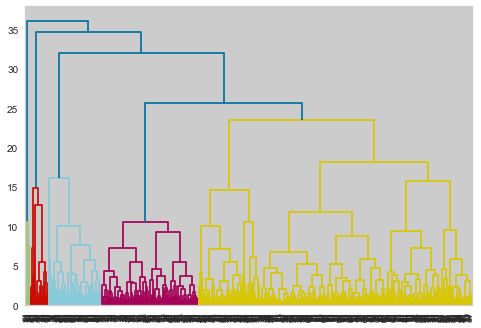

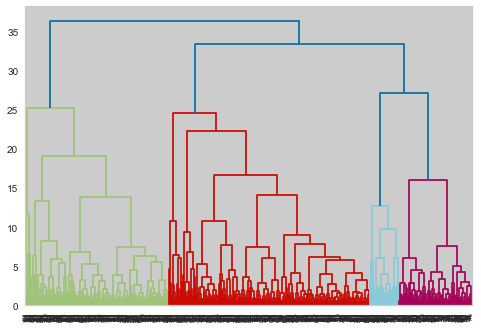

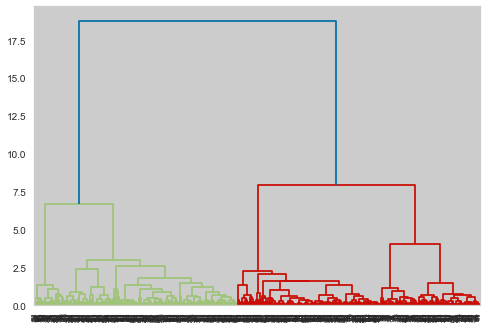

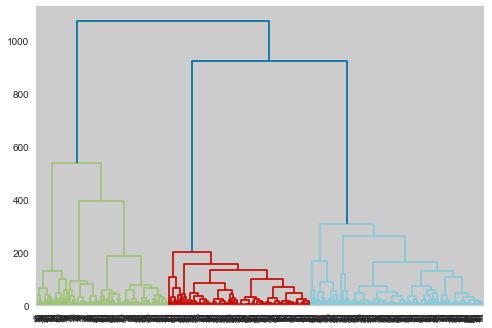

In [141]:
for data in [groupby_domains_RobustScaler,groupby_domains_StandardScaler,minmax, groupby_domains_clustering]:
    Z = linkage(data, 'ward') #'single', 'ward', ...
    dendrogram(Z)
    plt.show()

- ### ROBUSTSCALER transformation

In [24]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 15
clusters_hc = fcluster(linkage(groupby_domains_RobustScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([  9,  33,   8,  90, 177, 113, 231, 100,  57], dtype=int64))

In [25]:
cluster = AgglomerativeClustering(n_clusters=9)  
cluster.fit(groupby_domains_RobustScaler)
results_evaluation(cluster, groupby_domains_RobustScaler)

CLUSTERING DIVISION:
 6    231
4    177
2    113
8    100
3     90
5     57
0     33
1      9
7      8
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,152040.93,3560.20,2.67,78.02,95.91,2.39,20.80,0.37,67.46,38.74,7.68
1,114131.67,1296.13,1.74,40.48,38.71,0.41,6.67,0.11,30.40,9.10,1.21
2,153056.40,9077.97,6.53,86.11,96.12,1.55,121.04,1.42,71.24,25.88,10.24
3,145949.63,37059.29,26.60,83.96,99.13,1.68,170.11,0.50,77.86,27.23,21.32
4,251752.48,23700.61,10.38,84.27,97.65,1.67,186.29,0.78,75.85,42.08,71.89
5,247261.88,5417.43,2.95,77.21,94.42,1.61,24.40,0.39,56.52,13.07,17.79
6,179493.84,8390.10,4.52,85.27,96.83,1.67,43.45,0.46,77.32,41.20,12.93
7,156314.44,105649.65,68.23,89.13,98.87,1.73,517.26,0.53,83.31,30.72,28.95
8,181409.48,7568.09,5.13,82.53,96.41,1.85,45.92,0.70,68.70,29.26,18.51


The Silhouette Score is:  0.15432322212965055
The Calinski Harabasz Score is:  143.14992581085102
The Davies Douldin Score is:  1.3075342431144623


- ### STANDARDSCALER transformation

In [26]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 20
clusters_hc = fcluster(linkage(groupby_domains_StandardScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 12, 251,  26,  23, 320,  53, 133], dtype=int64))

In [27]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(groupby_domains_StandardScaler)
results_evaluation(cluster, groupby_domains_StandardScaler)

CLUSTERING DIVISION:
 2    369
0    263
1    133
3     53
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,173065.36,8088.75,5.53,79.81,93.65,1.64,53.75,0.53,67.91,5.96,12.15
1,284615.60,22821.72,9.09,83.17,97.49,1.70,131.61,0.66,75.39,37.78,80.69
2,173429.78,12233.93,7.70,85.76,97.30,1.72,105.47,0.83,74.44,55.60,17.60
3,162610.92,53910.72,34.74,85.07,99.26,1.68,232.18,0.47,80.15,9.58,32.57


The Silhouette Score is:  0.2124855068365062
The Calinski Harabasz Score is:  130.28878016196785
The Davies Douldin Score is:  1.5133224272588648


- ### MINMAX transformation

In [28]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 5
clusters_hc = fcluster(linkage(minmax, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([ 57, 317, 262, 182], dtype=int64))

In [29]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(minmax)
results_evaluation(cluster, minmax)

CLUSTERING DIVISION:
 1    317
2    262
0    182
3     57
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,263850.52,22951.95,9.98,84.48,97.27,1.69,166.96,0.74,75.48,58.61,62.27
1,164830.78,11332.42,8.56,81.20,94.86,1.67,68.89,0.60,69.84,4.24,12.91
2,155219.55,11434.13,8.01,85.85,97.03,1.71,84.62,0.76,74.14,58.61,8.19
3,263936.13,31032.35,12.57,80.62,97.64,1.67,148.61,0.61,75.43,4.40,80.28


The Silhouette Score is:  0.4788141757387472
The Calinski Harabasz Score is:  1107.8437781135492
The Davies Douldin Score is:  0.7545334899463183


- ### RAW transformation

In [30]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 450
clusters_hc = fcluster(linkage(groupby_domains_clustering, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([ 58, 184, 260, 316], dtype=int64))

In [31]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(groupby_domains_clustering)
results_evaluation(cluster, groupby_domains_clustering)

CLUSTERING DIVISION:
 1    316
2    260
0    184
3     58
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,262666.10,22848.99,9.96,84.50,97.26,1.69,166.67,0.74,75.45,58.61,61.91
1,164675.47,11239.07,8.51,81.20,94.85,1.67,67.50,0.60,69.86,4.23,12.74
2,155222.13,11418.40,8.01,85.85,97.03,1.71,84.19,0.76,74.15,58.61,8.03
3,263073.56,31201.28,12.78,80.64,97.68,1.66,154.80,0.65,75.22,4.42,80.01


The Silhouette Score is:  0.5046862258658974
The Calinski Harabasz Score is:  796.6834125360728
The Davies Douldin Score is:  0.6978883471385976


## DBSCAN

- First, I´m going to find the optimal value of eps, the value for which two points are considered neighbors if the distance between the two points is below the threshold epsilon. We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

- ### With MINMAX Scaler Data

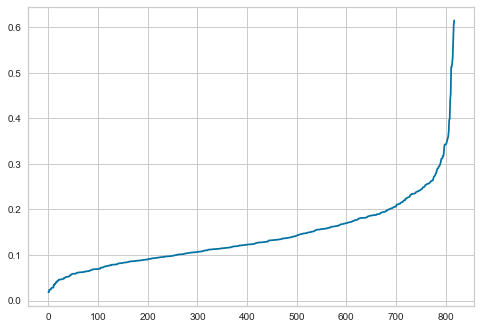

In [58]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(p=1)
nbrs = neigh.fit(minmax)
distances, indices = nbrs.kneighbors(minmax)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [59]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.1, min_samples=5)
dbs = dbs.fit(minmax)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 7 clusters


(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([284, 169, 343,   4,   5,   6,   7], dtype=int64))

In [60]:
results_evaluation(dbs,minmax)

CLUSTERING DIVISION:
  1    343
-1    284
 0    169
 5      7
 4      6
 3      5
 2      4
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
-1,179038.82,23543.61,14.27,79.97,94.84,1.70,147.37,0.73,69.84,22.43,31.45
0,186306.45,7734.17,5.06,84.04,96.22,1.67,44.55,0.54,72.90,4.39,8.82
1,196054.51,11646.28,6.33,86.15,97.42,1.69,87.73,0.73,75.84,58.61,30.91
2,359762.36,4836.77,2.13,71.81,97.59,1.80,15.24,0.27,44.21,3.83,2.00
3,317144.43,25047.51,8.78,79.57,96.92,1.66,114.81,0.48,73.08,4.51,81.09
4,129103.42,30080.33,24.68,85.92,98.77,1.62,224.27,0.72,65.35,58.61,7.33
5,372161.33,31573.74,9.11,77.20,97.70,1.65,201.68,0.72,71.36,1.83,94.70


The Silhouette Score is:  -0.11108151048039623
The Calinski Harabasz Score is:  120.66986467278123


- ### With Standard Scaler Data

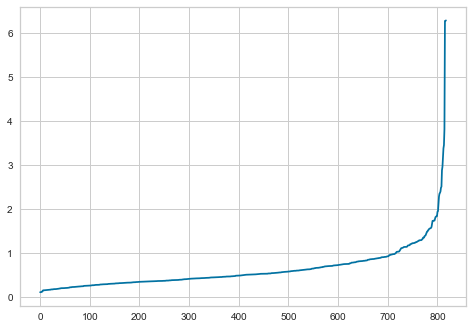

In [166]:
neigh = NearestNeighbors()
nbrs = neigh.fit(groupby_domains_StandardScaler)
distances, indices = nbrs.kneighbors(groupby_domains_StandardScaler)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [203]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=1, min_samples=5)
dbs = dbs.fit(groupby_domains_StandardScaler)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 9 clusters


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64),
 array([175,  24,  82, 203, 196,  11,  62,  40,  25], dtype=int64))

In [204]:
results_evaluation(dbs, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
  2    203
 3    196
-1    175
 1     82
 5     62
 6     40
 7     25
 0     24
 4     11
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
-1,371296.41,32359.63,10.90,78.55,92.22,1.70,206.79,0.78,66.36,0.29,0.86
0,302171.90,20111.95,7.28,85.24,97.27,1.72,146.40,0.78,75.76,0.59,3.00
1,166809.34,14200.78,9.96,85.57,97.33,1.67,107.06,0.76,76.25,0.59,2.00
2,119670.76,8643.14,8.28,83.41,96.94,1.69,53.18,0.56,72.42,0.04,0.00
3,120877.74,8125.92,7.33,86.54,97.90,1.70,57.81,0.70,76.16,0.59,0.00
4,221391.92,20106.73,10.67,82.84,98.53,1.67,120.94,0.65,72.00,0.04,3.00
5,147756.07,13173.67,9.51,84.43,97.03,1.69,100.14,0.74,74.54,0.59,1.00
6,167619.37,13045.23,9.64,81.18,97.49,1.66,84.59,0.66,75.86,0.05,2.00
7,151620.23,12685.73,9.48,84.38,97.60,1.62,53.43,0.49,73.71,0.05,1.00


The Silhouette Score is:  0.033401755430523164
The Calinski Harabasz Score is:  40.666820715295124


## OPTICS

In [32]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=20).fit(minmax)

In [33]:
results_evaluation(optics,minmax)

CLUSTERING DIVISION:
  1    444
-1    342
 0     32
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
-1,172121.75,13685.92,9.07,81.20,95.05,1.67,76.74,0.60,70.40,4.25,17.38
0,263439.97,21269.89,10.27,80.19,97.78,1.65,126.92,0.64,73.86,4.44,85.14
1,199748.46,16155.40,8.82,85.29,97.13,1.70,118.37,0.75,74.69,58.61,30.36


The Silhouette Score is:  0.496740319006036
The Calinski Harabasz Score is:  799.1457010135908
The Davies Douldin Score is:  0.640783325595596


## PCA + KMEANS

By reducing the number of features, we’re improving the performance of our algorithm. On top of that, by decreasing the number of features the noise is also reduced.
In the case of PCA and K-means in particular, there appears to be an even closer relationship between the two.

- **With the Robust Scaler data**

Text(0, 0.5, 'Cumulative explained variance')

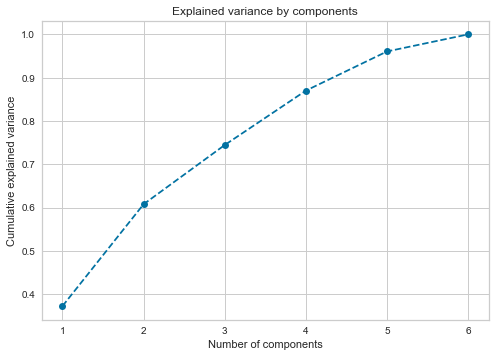

In [34]:
pca = PCA()
pca.fit(groupby_domains_RobustScaler)
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [35]:
pca_robustscaler = PCA(n_components=4)
pca_robustscaler = pca_robustscaler.fit_transform(groupby_domains_RobustScaler)

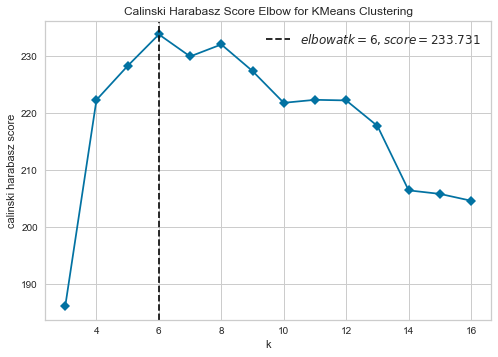

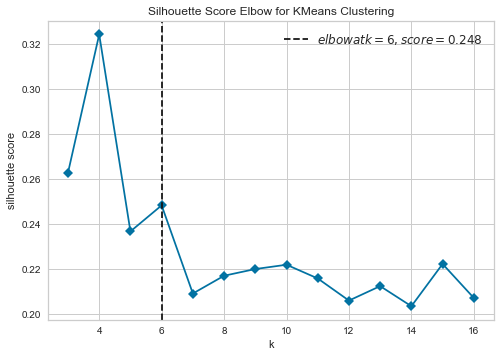

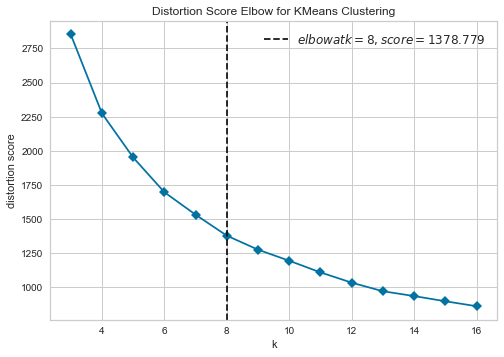

In [36]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_robustscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 5-7

In [37]:
kmeans_pca_robustscaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_robustscaler.fit(pca_robustscaler)
results_evaluation(kmeans_pca_robustscaler, pca_robustscaler)

CLUSTERING DIVISION:
 4    414
1    137
3    132
5     99
0     26
2     10
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,155877.96,3401.52,2.94,81.58,96.82,2.49,22.49,0.42,70.90,35.55,6.64
1,179968.13,12097.52,7.06,86.60,96.62,1.60,164.35,1.48,70.42,37.51,26.37
2,113392.25,1355.62,1.80,45.37,44.25,0.46,9.20,0.25,33.80,14.05,1.16
3,201581.86,6987.35,3.90,77.87,95.45,1.76,32.82,0.51,59.14,21.63,17.30
4,197395.33,11615.95,6.48,84.76,96.99,1.67,68.42,0.54,77.87,36.82,29.45
5,179910.89,50944.73,31.16,84.82,99.09,1.68,272.84,0.54,78.07,33.47,39.12


The Silhouette Score is:  0.2476258472019498
The Calinski Harabasz Score is:  233.73054582702252
The Davies Douldin Score is:  1.072648133110236


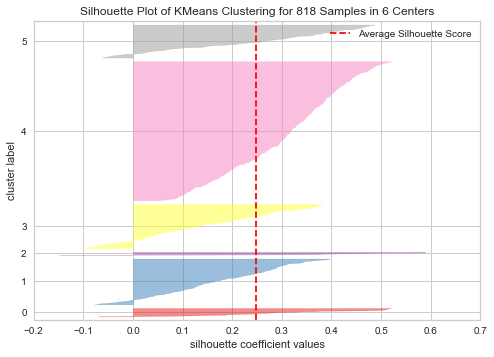

In [38]:
sv = SilhouetteVisualizer(kmeans_pca_robustscaler)
sv.fit(pca_robustscaler)
sv.show()

- **With the Standard Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

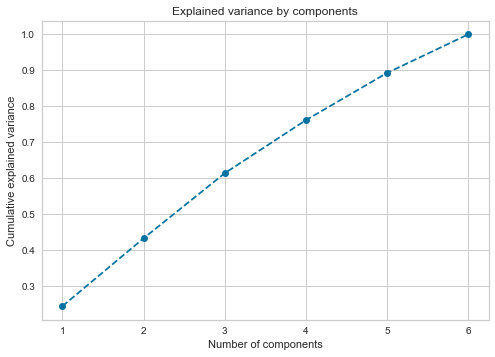

In [39]:
pca = PCA()
pca.fit(groupby_domains_StandardScaler)
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [40]:
pca_standardscaler = PCA(n_components=5)
pca_standardscaler = pca_standardscaler.fit_transform(groupby_domains_StandardScaler)

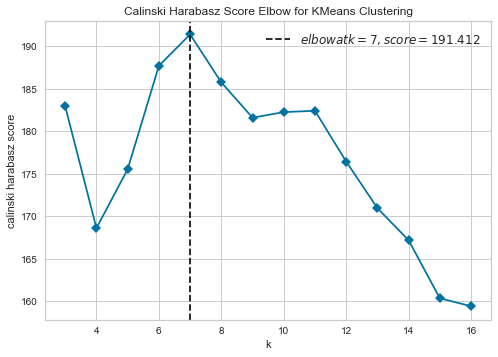

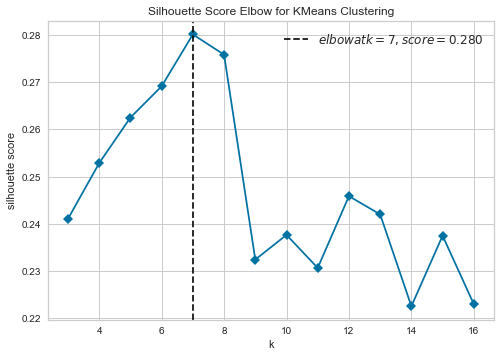

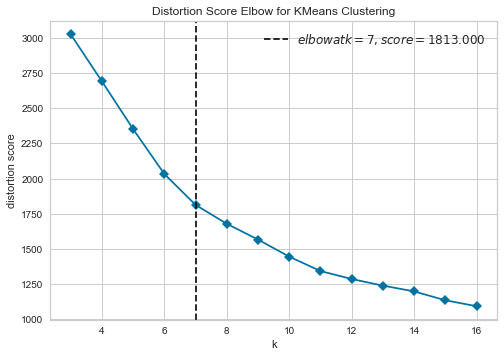

In [41]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_standardscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [42]:
kmeans_pca_standardscaler = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_robustscaler.fit(pca_standardscaler)
results_evaluation(kmeans_pca_robustscaler, pca_standardscaler)

CLUSTERING DIVISION:
 0    274
1    245
5    152
3     72
4     60
2     15
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,187478.26,10527.24,6.10,85.26,97.17,1.73,67.93,0.62,75.39,58.42,15.53
1,177068.33,8037.45,5.51,81.44,96.08,1.73,47.16,0.50,69.36,4.92,13.06
2,117884.51,1389.07,1.31,48.05,55.16,0.80,5.52,0.10,34.51,17.54,2.06
3,152781.67,48963.59,33.28,86.62,99.22,1.66,239.72,0.56,81.17,18.84,27.53
4,131546.92,7359.17,6.07,87.35,96.62,1.60,145.22,1.94,69.38,36.67,12.74
5,266920.29,24294.82,10.15,83.50,97.55,1.68,175.26,0.72,75.18,43.32,78.39


The Silhouette Score is:  0.27073308704562354
The Calinski Harabasz Score is:  185.07244770440693
The Davies Douldin Score is:  1.1354921061677796


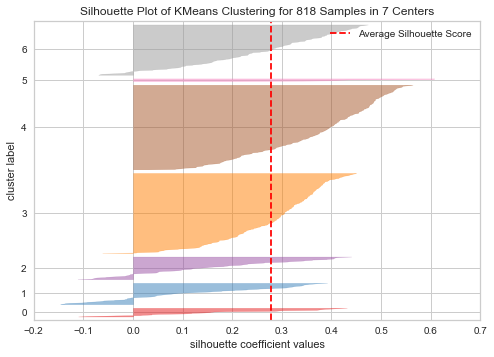

In [43]:
sv = SilhouetteVisualizer(kmeans_pca_standardscaler)
sv.fit(pca_standardscaler)
sv.show()

- **With the Minmax Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

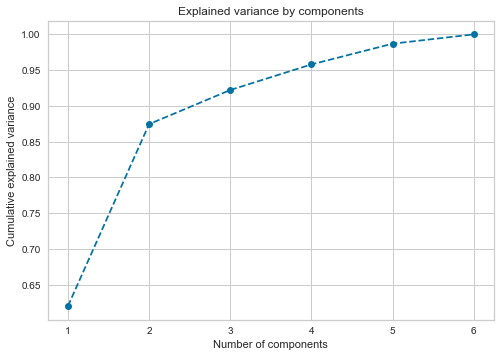

In [44]:
pca = PCA()
pca.fit(minmax)
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [50]:
pca_minmax = PCA(n_components=2)
pca_minmax = pca_minmax.fit_transform(minmax)

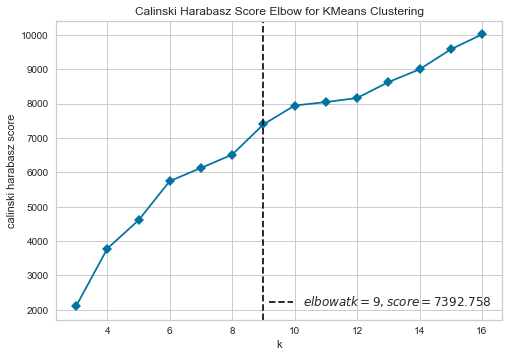

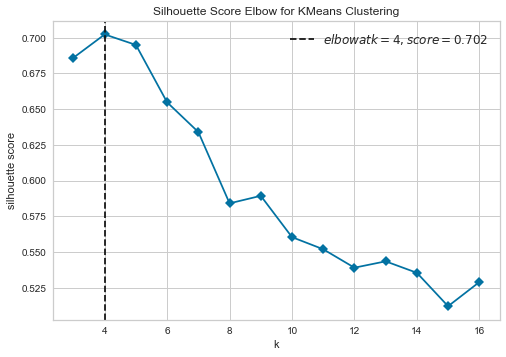

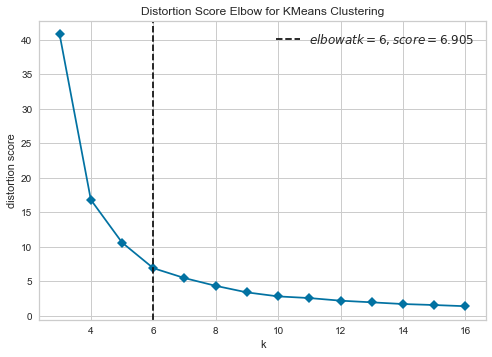

In [51]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_minmax, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [59]:
kmeans_pca_minmax = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 1    290
2    256
0    110
3     84
4     78
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,231242.85,15844.94,8.99,84.34,96.87,1.69,116.63,0.77,74.45,58.61,43.19
1,165781.36,10728.58,8.16,81.09,94.57,1.67,64.65,0.59,69.72,4.16,9.68
2,155824.90,11320.96,7.87,86.04,97.02,1.71,83.48,0.76,74.42,58.61,7.71
3,228799.09,26784.91,12.68,81.21,97.77,1.67,137.61,0.65,74.05,4.62,69.77
4,299492.66,32460.10,11.68,84.17,97.82,1.70,235.32,0.70,75.92,58.61,86.59


The Silhouette Score is:  0.6948704496128072
The Calinski Harabasz Score is:  4603.581382404213
The Davies Douldin Score is:  0.4429496563444231


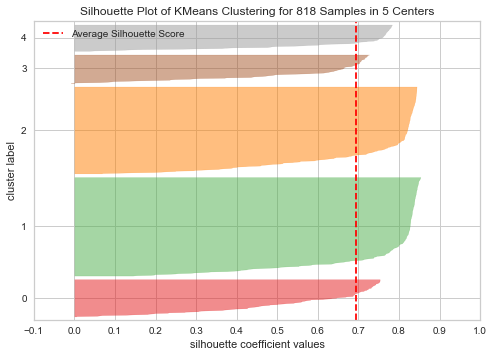

In [60]:
sv = SilhouetteVisualizer(kmeans_pca_minmax)
sv.fit(pca_minmax)
sv.show()

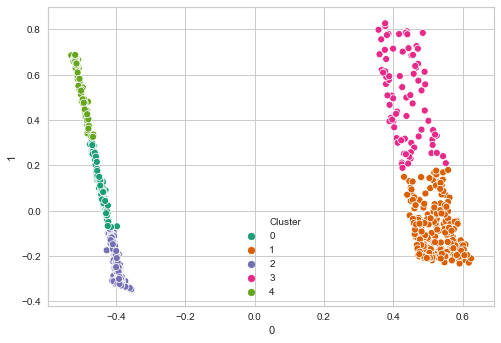

In [61]:
pca_minmax_df = pd.DataFrame(pca_minmax.copy())
pca_minmax_df['Cluster'] = kmeans_pca_minmax.labels_
sns.scatterplot(pca_minmax_df[0],pca_minmax_df[1],hue=pca_minmax_df['Cluster'], palette='Dark2')

- **With the orginal/raw Data**

Text(0, 0.5, 'Cumulative explained variance')

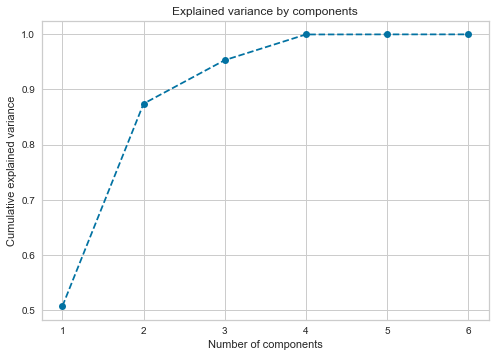

In [62]:
pca = PCA()
pca.fit(groupby_domains_clustering)
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [63]:
pca_rawdata = PCA(n_components=2)
pca_rawdata = pca_rawdata.fit_transform(groupby_domains_clustering)

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


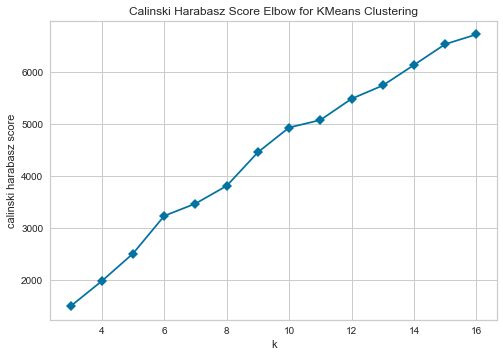

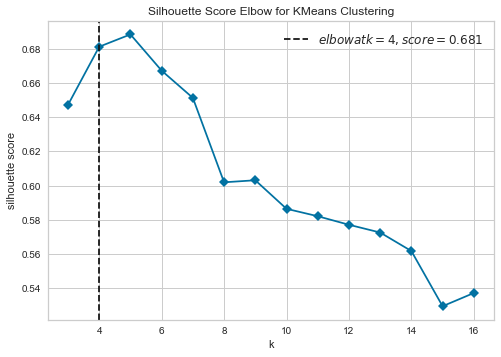

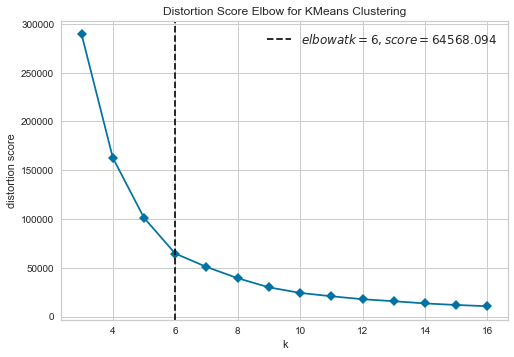

In [64]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_rawdata, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [65]:
kmeans_pca_rawdata = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_rawdata.fit(pca_rawdata)
results_evaluation(kmeans_pca_rawdata, pca_rawdata)

CLUSTERING DIVISION:
 0    290
1    257
4    111
3     84
2     76
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,165781.36,10728.58,8.16,81.09,94.57,1.67,64.65,0.59,69.72,4.16,9.68
1,155615.40,11339.62,7.90,86.02,97.03,1.71,83.71,0.76,74.37,58.61,7.78
2,304747.43,32841.49,11.48,84.37,97.81,1.70,240.11,0.71,75.95,58.61,87.17
3,228799.09,26784.91,12.68,81.21,97.77,1.67,137.61,0.65,74.05,4.62,69.77
4,230039.22,15880.74,9.11,84.24,96.88,1.69,115.27,0.77,74.57,58.61,43.73


The Silhouette Score is:  0.6883246205372793
The Calinski Harabasz Score is:  2504.5381943580605
The Davies Douldin Score is:  0.4534762332919254


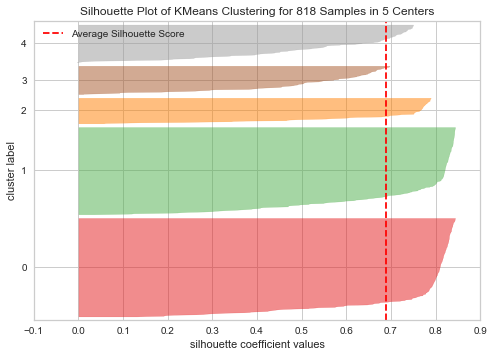

In [66]:
sv = SilhouetteVisualizer(kmeans_pca_rawdata)
sv.fit(pca_rawdata)
sv.show()

In [108]:
raw_cluster = groupby_domains_clustering.copy()
raw_cluster['Cluster'] = kmeans_pca_rawdata.labels_
raw_cluster.groupby('Cluster').mean()

,Format Fill Rate,CPM,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,
0,7.90,1.71,0.76,74.37,58.61,7.78
1,7.14,1.67,0.59,69.10,4.23,6.07
2,11.68,1.70,0.70,75.92,58.61,86.59
3,13.09,1.66,0.63,75.31,4.58,81.43
4,12.91,1.66,0.65,72.47,4.14,36.09
5,8.92,1.69,0.77,74.56,58.61,43.35


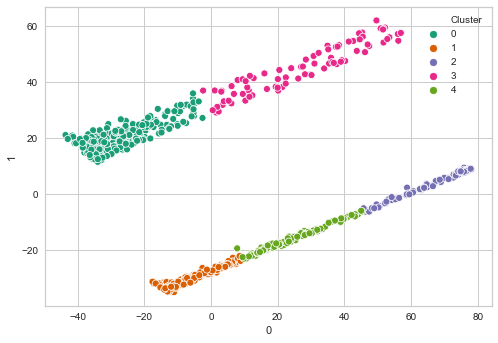

In [67]:
pca_rawdata_df = pd.DataFrame(pca_rawdata.copy())
pca_rawdata_df['Cluster'] = kmeans_pca_rawdata.labels_
sns.scatterplot(pca_rawdata_df[0],pca_rawdata_df[1],hue=pca_rawdata_df['Cluster'], palette='Dark2')

- ### Conclussions:

K-Means + PCA transformation with the Minmax Scaler data gives a significant better result than the K-Means algorithm without PCA. The Silhouette Score with 8 cluster is about 90%.

## K-MEDOIDS

- ### With the Robust Scaler Data

In [71]:
cd FINAL-PROJECT-OF-KSCHOOL-MASTER

C:\Users\Usuario\Google Drive\FINAL-PROJECT-OF-KSCHOOL-MASTER


In [72]:
%run KMEDOIDS.py

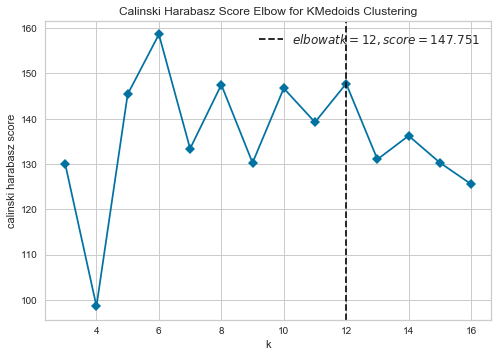

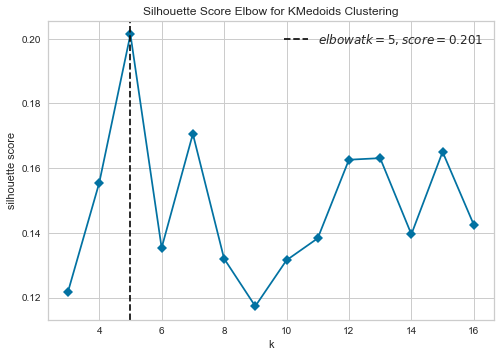

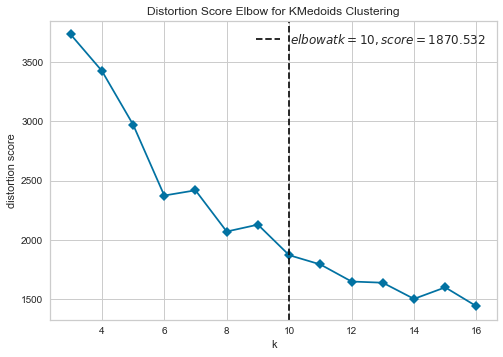

In [75]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')

visualization_clusters(groupby_domains_RobustScaler,model)

In [76]:
kmedoids_robust = KMedoids(n_clusters = 6, init= 'k-medoids++')
kmedoids_robust.fit(groupby_domains_RobustScaler)
results_evaluation(kmedoids_robust, groupby_domains_RobustScaler )

CLUSTERING DIVISION:
 2    238
0    230
3    194
5    122
1     27
4      7
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,240765.20,23528.12,11.14,85.20,97.95,1.68,148.81,0.72,77.71,48.56,54.24
1,153032.18,3276.78,2.83,79.30,96.49,2.47,21.65,0.40,68.37,34.44,6.45
2,189458.02,6482.76,3.84,81.62,95.95,1.76,44.38,0.75,65.18,35.51,22.01
3,168766.97,7027.46,4.93,83.12,95.48,1.61,27.48,0.35,76.84,20.45,10.66
4,124266.08,1642.46,2.20,33.80,35.51,0.29,8.57,0.14,26.61,3.04,1.35
5,145692.67,33742.27,23.12,87.55,98.53,1.60,263.11,1.11,76.04,25.22,17.87


The Silhouette Score is:  0.12092773318481326
The Calinski Harabasz Score is:  133.08549422257286
The Davies Douldin Score is:  1.5301333822588046


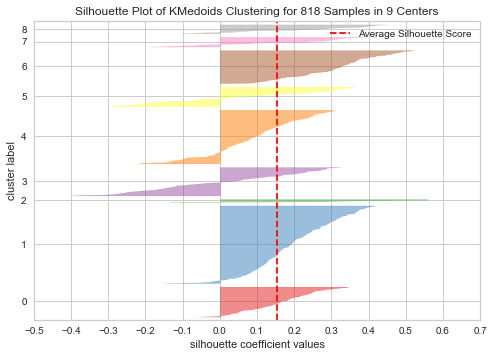

In [115]:
sv = SilhouetteVisualizer(kmedoids_robust)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the Standard Scaler Data

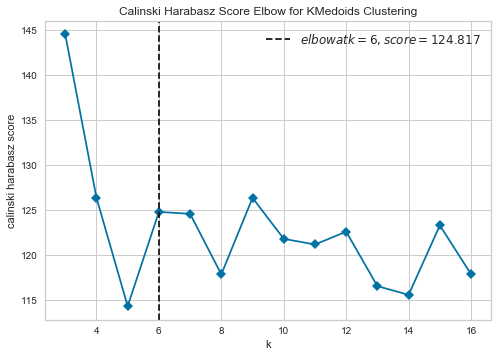

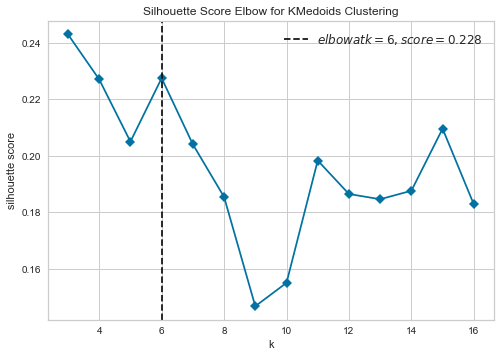

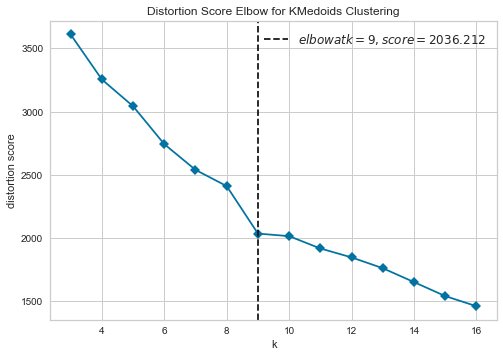

In [77]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(groupby_domains_StandardScaler,model)

In [78]:
kmedoids_standard = KMedoids(n_clusters = 6, init= 'k-medoids++')
kmedoids_standard.fit(groupby_domains_StandardScaler)
results_evaluation(kmedoids_standard, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
 0    288
2    227
3    110
5     80
1     66
4     47
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,168314.77,8709.75,6.32,80.67,94.56,1.67,54.78,0.55,69.19,4.22,12.78
1,145217.92,6889.24,5.55,88.47,96.92,1.63,125.63,1.80,71.42,50.26,10.37
2,175989.71,10122.40,6.31,84.20,96.68,1.74,54.06,0.52,74.09,58.61,11.57
3,227518.45,18563.82,8.94,86.56,97.39,1.66,198.17,0.94,75.65,50.71,59.82
4,172366.85,62989.56,40.14,85.79,99.32,1.69,283.43,0.50,80.39,20.64,36.10
5,310588.28,28385.08,10.69,80.84,97.53,1.70,142.58,0.50,75.52,40.41,85.99


The Silhouette Score is:  0.18120659343522033
The Calinski Harabasz Score is:  122.18622937210988
The Davies Douldin Score is:  1.6018427651646263


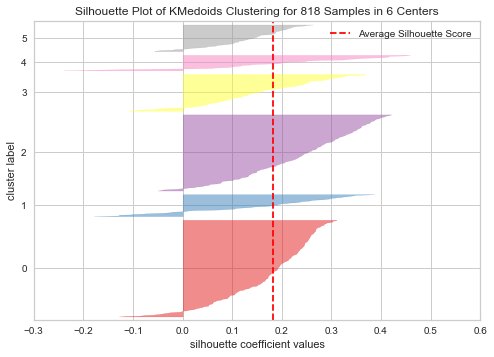

In [79]:
sv = SilhouetteVisualizer(kmedoids_standard)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the MinMax Scaler Data

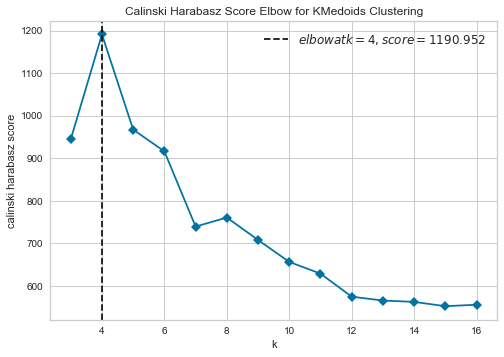

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


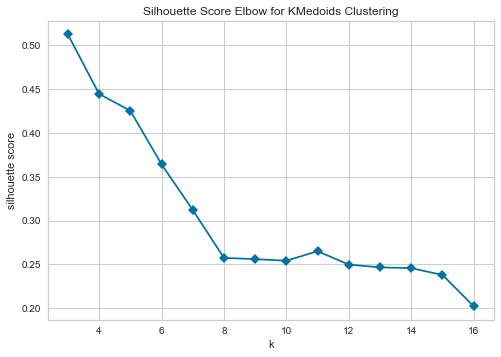

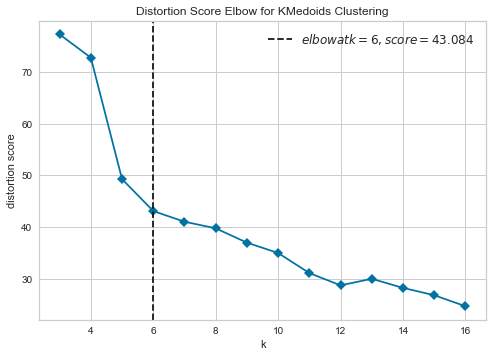

In [80]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(minmax,model)

In [81]:
kmedoids_minmax = KMedoids(n_clusters = 5, init= 'k-medoids++')
kmedoids_minmax.fit(minmax)
results_evaluation(kmedoids_minmax, minmax )

CLUSTERING DIVISION:
 0    318
1    194
3    126
2    114
4     66
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,175135.87,12161.76,8.05,85.45,97.00,1.71,86.63,0.75,74.25,58.61,13.09
1,138499.05,5581.36,5.06,79.50,93.12,1.68,30.56,0.51,67.53,4.17,4.26
2,209847.12,21168.50,14.59,84.08,97.65,1.66,131.31,0.73,74.06,4.30,24.28
3,261865.95,26234.59,10.74,84.87,97.45,1.69,198.48,0.77,75.80,58.61,73.95
4,250065.60,28261.02,11.88,80.73,97.57,1.67,142.56,0.65,74.15,4.48,76.87


The Silhouette Score is:  0.38849085077349127
The Calinski Harabasz Score is:  984.7736680302643
The Davies Douldin Score is:  1.17543354756123


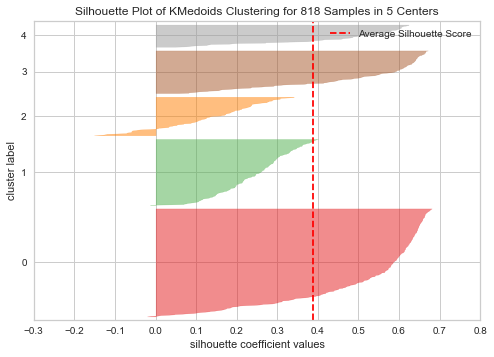

In [82]:
sv = SilhouetteVisualizer(kmedoids_minmax)
sv.fit(minmax)
sv.show()

- ### With the Raw Data

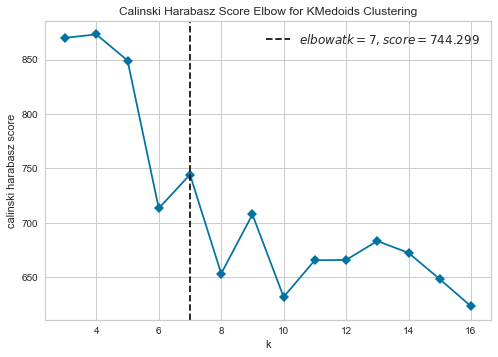

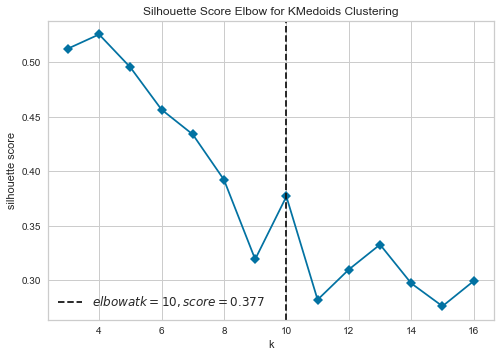

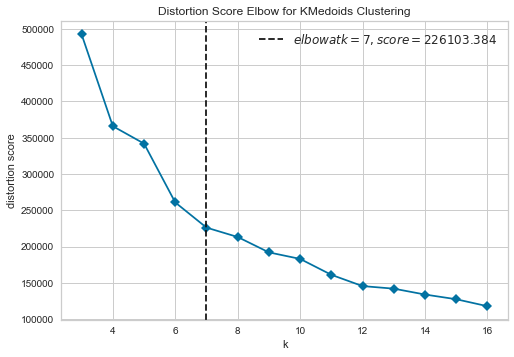

In [83]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(groupby_domains_clustering,model)

In [88]:
kmedoids_raw = KMedoids(n_clusters = 5, init= 'k-medoids++')
kmedoids_raw.fit(groupby_domains_clustering)
results_evaluation(kmedoids_raw, groupby_domains_clustering )

CLUSTERING DIVISION:
 1    292
0    253
4    114
3     82
2     77
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,156239.05,11348.87,7.88,86.02,97.05,1.71,83.21,0.76,74.44,58.61,7.51
1,165274.86,10699.09,8.15,81.09,94.60,1.67,64.48,0.59,69.65,4.16,9.89
2,302113.65,32636.16,11.57,84.38,97.83,1.70,238.02,0.71,75.97,58.61,86.88
3,232139.74,27281.56,12.81,81.22,97.73,1.67,140.01,0.65,74.40,4.63,70.47
4,227167.41,15690.78,9.04,84.29,96.81,1.69,115.58,0.77,74.39,58.61,42.89


The Silhouette Score is:  0.5002436457123516
The Calinski Harabasz Score is:  861.2174907296418
The Davies Douldin Score is:  0.7082565150979356


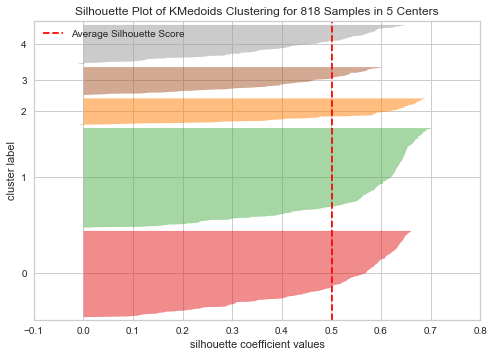

In [89]:
sv = SilhouetteVisualizer(kmedoids_raw)
sv.fit(groupby_domains_clustering)
sv.show()

- **With the PCA scores**

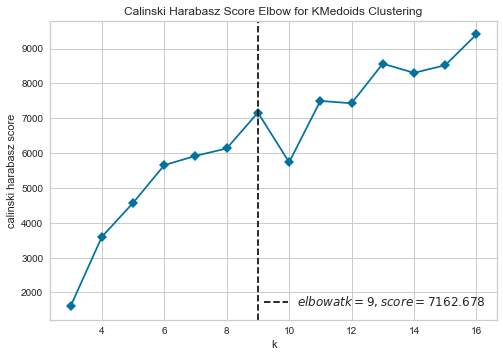

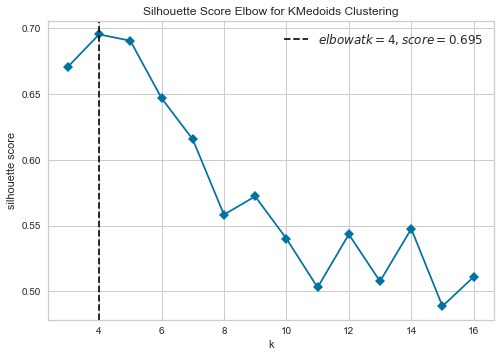

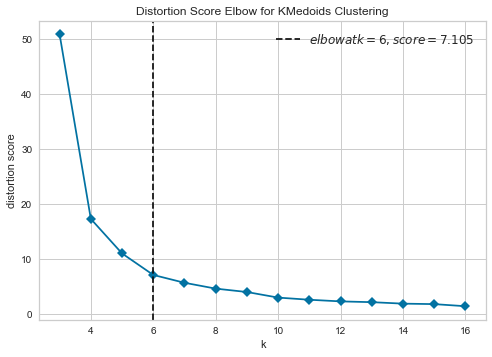

In [90]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(pca_minmax,model)

In [91]:
kmedoids_pca_minmax = KMedoids(n_clusters = 5, init= 'k-medoids++')
kmedoids_pca_minmax.fit(pca_minmax)
results_evaluation(kmedoids_pca_minmax, pca_minmax )

CLUSTERING DIVISION:
 2    286
0    203
1    158
4    104
3     67
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,135323.22,6906.54,6.49,80.57,93.59,1.67,42.75,0.59,68.39,4.19,4.04
1,269451.68,24848.67,10.42,84.47,97.45,1.69,181.48,0.76,75.57,58.61,66.94
2,161241.09,11352.82,7.93,85.74,96.95,1.71,83.51,0.75,74.21,58.61,10.15
3,247922.59,28545.02,12.35,80.79,97.60,1.67,142.01,0.65,74.27,4.53,76.43
4,223214.33,19679.59,12.36,82.39,97.10,1.67,116.49,0.60,72.88,4.23,26.21


The Silhouette Score is:  0.6202214863801644
The Calinski Harabasz Score is:  3370.082159936806
The Davies Douldin Score is:  0.566889102079705


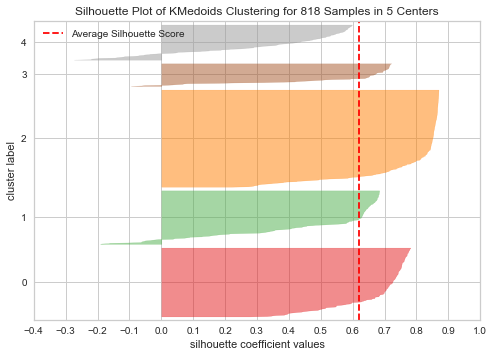

In [92]:
sv = SilhouetteVisualizer(kmedoids_pca_minmax)
sv.fit(pca_minmax)
sv.show()

# *TESTS RESULTS*

In [95]:
tests_results = pd.read_csv('RESULTS CLUSTERING TESTS.csv')

In [96]:
tests_results.sort_values(by= 'SILHOUETTE SCORE', ascending =False).head(5)

,DATA TRANSFORMATION,ALGORITHM,NºCLUSTERS,SILHOUETTE SCORE,CALINSKI HARABASZ SCORE
10,MMS,PCA+KMEANS,4,70,3778
16,MMS,KMEDOID + PCA,4,69,3636
11,RAW,PCA+KMEANS,6,66,3228
15,RAW,KMEDOIDS,4,53,892
2,MMS,KMEANS,4,"50,28",1205


- ***I´ll work with the clustering with the best Silhouette score and Calinski Harabasz Score***

In [116]:
kmeans_pca_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=5, algorithm='auto')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 0    318
1    290
3    126
2     84
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,175135.87,12161.76,8.05,85.45,97.00,1.71,86.63,0.75,74.25,58.61,13.09
1,165781.36,10728.58,8.16,81.09,94.57,1.67,64.65,0.59,69.72,4.16,9.68
2,228799.09,26784.91,12.68,81.21,97.77,1.67,137.61,0.65,74.05,4.62,69.77
3,261865.95,26234.59,10.74,84.87,97.45,1.69,198.48,0.77,75.80,58.61,73.95


The Silhouette Score is:  0.7022258385733642
The Calinski Harabasz Score is:  3778.8902506782288
The Davies Douldin Score is:  0.45511638409711413


## CLUSTER ANALYSIS

In [117]:
clusters = groupby_domains_clustering.copy()
clusters['Cluster'] = kmeans_pca_minmax.labels_
cluster1 = clusters[clusters['Cluster']==0]
cluster2 = clusters[clusters['Cluster']==1]
cluster3 = clusters[clusters['Cluster']==2]
cluster4 = clusters[clusters['Cluster']==3]


clusters.groupby('Cluster').mean()

,Format Fill Rate,CPM,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,
0,8.05,1.71,0.75,74.25,58.61,13.09
1,8.16,1.67,0.59,69.72,4.16,9.68
2,12.68,1.67,0.65,74.05,4.62,69.77
3,10.74,1.69,0.77,75.80,58.61,73.95


**CLUSTER 1**: 318 Domains. All the domains belongs to the News & Portals category. In general the Domains are no recurrent (max 44%).  

**CLUSTER 2**: 290 domains. The Domains are no recurrent (max 37%), and belong to all the monority categories. The main categories are Community&Culture, Tech&Gaming, and Movies&Television. The Format Fill Rate is low, only 11 domains have a format fill rate beyond 30%

**CLUSTER 3**: 84 domains. The Domains are also recurrent, the mean is 69.77% and all of them are in the range 44-100%. The domains belong to all the monority categories. The main categories are Community&Culture and Sports

**CLUSTER 4**: 126 domains. The Domains are really recurrent, the mean is 73.95% and all of them are in the range 44-100%. All the domains belongs to the News & Portals category. 52% of the domains have a 50% View Rate more than 77%


**We can see in this first clustering that the decisive variables have been the Category importance and the Domain recurrence.**
- Cluster1 and Cluster2 have low recurrence but the difference is that in the cluster2 all the domains are from the News&Portal Category.
- Cluster3 and Cluster4 have high recurrence but the difference is the same: in the Cluster3 we only have the News&Portals category, and in Cluster4 we have the rest of the categories

**NOTE**: ***The kmeans_pca_minmax clustering with k=5 generate an slightly better result, but I decide to keep k=4 beacuse it has more "business sense", we can markedly appreciate the differences between clusters***

## SUBCLUSTERING

- I´m gonna apply a new clustering over data to define subclusters and make a better grouping

- For this new clustering I am going to use 3 variables: FORMAT LOADS, IMPRESSIONS AND CLICKS. These are the 3 more important variables that I didn´t use in the first clustering. I chose not to use them because the scale is extremely higher that the scale of the percentage variables, so I hope these variables will give me some interesting clusters, after this first general division. 

In [303]:
subclustering = groupby_domains[['Format Loads', 'Impressions', 'Clicks']].copy()
subclustering['Cluster'] = clusters['Cluster']

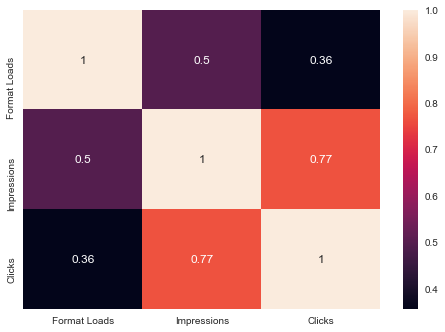

In [159]:
sns.heatmap(subclustering.drop('Cluster', 1).corr(), annot=True)

**PCA is a way to deal with highly correlated variables, so there is no need to remove them**


Text(0, 0.5, 'Cumulative explained variance')

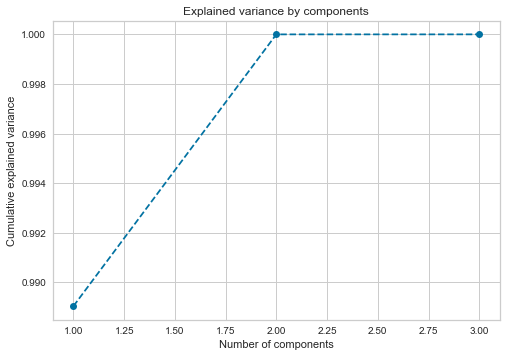

In [160]:
pca = PCA()
pca.fit(subclustering.drop('Cluster', 1))
plt.plot(range(1,4), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

- **It seems that the 3 variables are really well explained in ony one component, which comprehend almost the 99% of the explained variance**

In [342]:
pca=PCA(n_components=2)
new_clustering_pca = pd.DataFrame(pca.fit_transform(new_clustering.drop('Cluster', 1)))
new_clustering_pca['Cluster'] = clusters['Cluster']

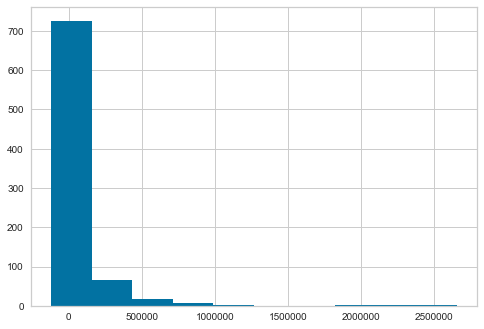

In [125]:
new_clustering_pca[0].hist();

- **NOTE : I did the subclustering proccess applying MinMax Scaler and Robust Scaler, but the results and the quality of the cluster were practically identical to the subclustering without preprocessing**

### SUBCLUSTERING: CLUSTER 1

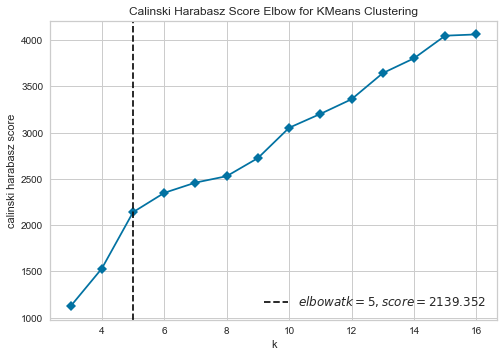

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


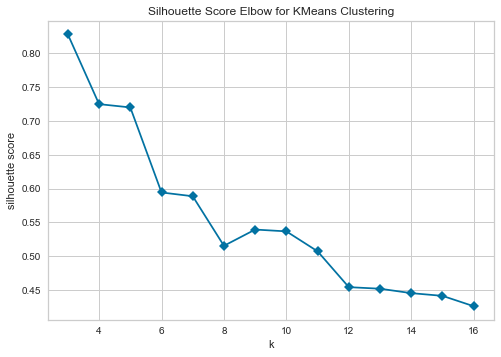

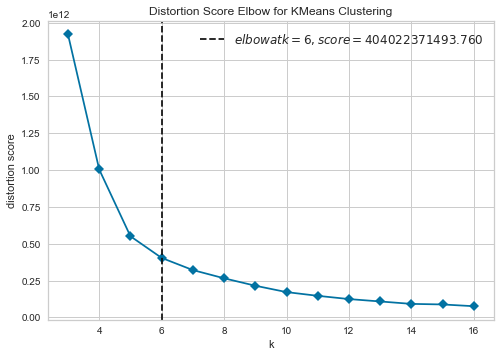

In [343]:
cluster1= new_clustering_pca[new_clustering_pca['Cluster']==0].copy()
cluster1.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(cluster1, model)

- I have to modify the results_evaluation function so it works with the shape of each cluster:

In [128]:

def results_evaluation_subclusters(model, data, cluster_number):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = new_clustering[new_clustering['Cluster']==cluster_number].copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))


In [357]:
kmeans_cluster1 = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=15, algorithm='auto')
kmeans_cluster1.fit(cluster1)
results_evaluation_subclusters(kmeans_cluster1, cluster1, 0)

CLUSTERING DIVISION:
 0    250
4     44
2     18
1      4
3      2
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,105641.80,9533.71,72.44
1,920433.23,37510.18,406.31
2,534730.73,17283.55,119.52
3,2285391.99,226923.54,702.40
4,259206.49,12932.29,96.71


The Silhouette Score is:  0.7201019206413453
The Calinski Harabasz Score is:  2143.0706227947
The Davies Douldin Score is:  0.4057704744891801


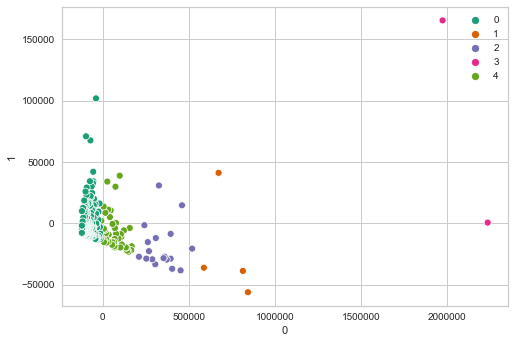

In [359]:
sns.scatterplot(cluster1[0], cluster1[1], hue=kmeans_cluster1.labels_,palette='Dark2')

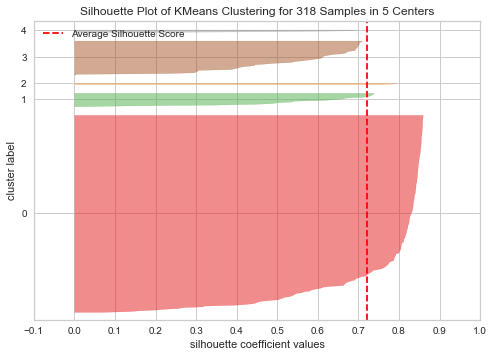

In [346]:
sv = SilhouetteVisualizer(kmeans_cluster1)
sv.fit(cluster1)
sv.show()

In [347]:
subclusters1 = subclustering[subclustering['Cluster']==0].copy()
subclusters1['Subcluster'] = kmeans_cluster1.labels_

In [348]:
pd.options.display.max_columns=None
subclusters1.drop('Cluster', 1).groupby('Subcluster').describe()

Format Loads                                                        \
                  count       mean       std        min        25%        50%   
Subcluster                                                                      
0                250.00  105641.80  25453.58   70783.00   86219.55   98958.00   
1                 18.00  534730.73  84049.23  403045.30  465664.95  530357.97   
2                  2.00 2285391.99 191820.79 2149754.21 2217573.10 2285391.99   
3                 44.00  259206.49  51022.85  183683.98  213365.28  260152.08   
4                  4.00  920433.23 121200.45  779779.16  840047.85  932947.60   

                                 Impressions                                \
                  75%        max       count      mean       std       min   
Subcluster                                                                   
0           119752.50  180138.50      250.00   9533.71  13538.74      1.00   
1           586359.32  710434.21       18.00  17283.55  18952.04    705.25   
2          2353210.88 2421029.77        2.00 226923.54 104978.33 152692.65   
3           297784.10  360474.26       44.00  12932.29  13945.34      9.00   
4          1013332.97 1036058.56        4.00  37510.18  40572.64  10881.81   

                                                   Clicks                \
                 25%       50%       75%       max  count   mean    std   
Subcluster                                                                
0            1666.70   5312.75  11355.63 114621.00 250.00  72.44 117.87   
1            3937.56   9649.16  25441.77  66088.86  18.00 119.52 120.10   
2          189808.09 226923.54 264038.98 301154.43   2.00 702.40 815.41   
3            3480.80   8492.44  17433.75  60142.10  44.00  96.71 117.65   
4           14093.51  20794.69  44211.36  97569.52   4.00 406.31 573.71   

                                                
              min    25%    50%    75%     max  
Subcluster                                      
0            0.00   8.27  31.72  86.51 1076.00  
1            3.78  25.54  89.39 150.78  440.67  
2          125.82 414.11 702.40 990.69 1278.98  
3            0.00  24.32  54.50 111.29  540.93  
4           51.88 113.53 154.97 447.75 1263.40

- Cluster 1 subgroup 1: 44 domains. Format loads between 183.000 and 360.000. Impressions very spread, the mean is 13.000.
- Cluster 1 subgroup 2:
- Cluster 1 subgroup 3:
- Cluster 1 subgroup 4:
- Cluster 1 subgroup 5:

        

### SUBCLUSTERING: CLUSTER 2

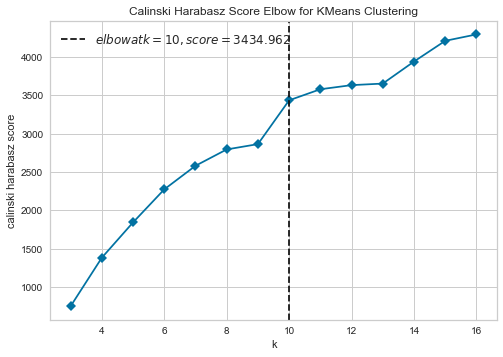

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


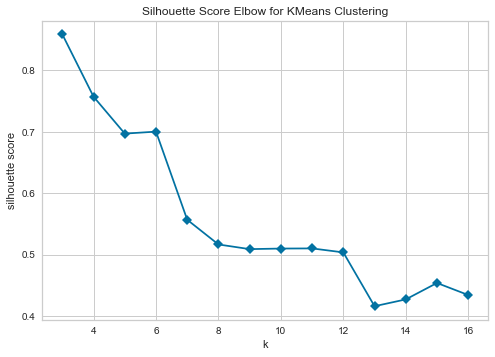

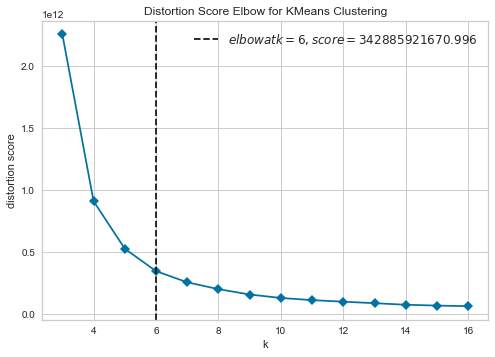

In [364]:
cluster2= new_clustering_pca[new_clustering_pca['Cluster']==1].copy()
cluster2.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(cluster2, model)

In [365]:
kmeans_cluster2 = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_cluster2.fit(cluster2)
results_evaluation_subclusters(kmeans_cluster2, cluster2, 1)

CLUSTERING DIVISION:
 0    219
5     47
3     16
4      5
1      2
2      1
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,97981.38,8562.27,55.28
1,1179162.07,37613.91,202.19
2,2849893.77,9517.08,48.92
3,434741.14,24734.94,182.54
4,823775.24,28739.27,186.69
5,219908.91,13020.24,49.67


The Silhouette Score is:  0.6999129024549613
The Calinski Harabasz Score is:  2274.8166671282697
The Davies Douldin Score is:  0.3621426551084627


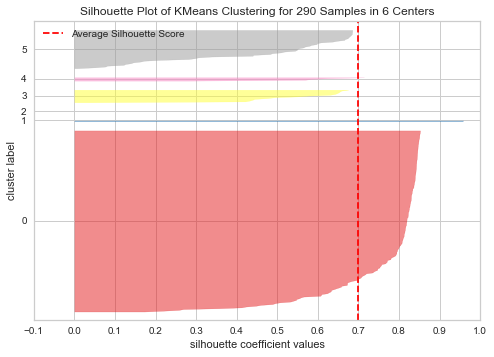

In [366]:
sv = SilhouetteVisualizer(kmeans_cluster2)
sv.fit(cluster2)
sv.show()

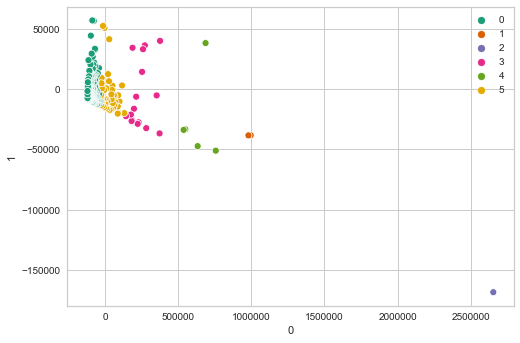

In [367]:
sns.scatterplot(cluster2[0], cluster2[1], hue=kmeans_cluster2.labels_,palette='Dark2')

In [218]:
subclusters2 = subclustering[subclustering['Cluster']==1].copy()
subclusters2['Subcluster'] = kmeans_cluster2.labels_

In [224]:
subclusters2.drop('Cluster', 1).groupby('Subcluster').describe()

Format Loads                                                       \
                  count       mean      std        min        25%        50%   
Subcluster                                                                     
0                 47.00  219908.91 44410.91  161163.27  180614.65  217049.41   
1                  1.00 2849893.77      nan 2849893.77 2849893.77 2849893.77   
2                  5.00  823775.24 92417.51  729254.05  740544.00  825563.60   
3                 16.00  434741.14 71363.18  334918.50  376229.13  418470.27   
4                219.00   97981.38 19850.91   71282.00   81245.36   92889.00   
5                  2.00 1179162.07 10822.40 1171509.48 1175335.78 1179162.07   

                                 Impressions                             \
                  75%        max       count     mean      std      min   
Subcluster                                                                
0           248152.20  323381.00       47.00 13020.24 15533.18     0.00   
1          2849893.77 2849893.77        1.00  9517.08      nan  9517.08   
2           874224.55  949290.00        5.00 28739.27 37602.99  6948.47   
3           463605.50  565105.00       16.00 24734.94 29075.34   131.75   
4           110953.02  153745.28      219.00  8562.27 10951.23     0.00   
5          1182988.37 1186814.67        2.00 37613.91   732.95 37095.63   

                                               Clicks                       \
                25%      50%      75%      max  count   mean    std    min   
Subcluster                                                                   
0           3145.14  7685.73 17155.94 67061.22  47.00  49.67  62.24   0.00   
1           9517.08  9517.08  9517.08  9517.08   1.00  48.92    nan  48.92   
2          10757.33 14537.70 15729.86 95723.00   5.00 186.69 272.29   5.43   
3           1465.60  8216.99 49275.57 78502.40  16.00 182.54 271.69   0.50   
4           1547.53  4799.50 11385.00 67352.38 219.00  55.28  82.23   0.00   
5          37354.77 37613.91 37873.04 38132.18   2.00 202.19  56.26 162.41   

                                        
              25%    50%    75%    max  
Subcluster                              
0            3.50  23.61  68.50 282.47  
1           48.92  48.92  48.92  48.92  
2           44.00  65.14 155.16 663.74  
3            3.29  32.17 275.04 956.71  
4            5.53  21.25  69.56 426.85  
5          182.30 202.19 222.08 241.97

- Cluster 2 subgroup 1:
- Cluster 2 subgroup 2:
- Cluster 2 subgroup 3:
- Cluster 2 subgroup 4:
- Cluster 2 subgroup 5:
- Cluster 2 subgroup 6:



### SUBCLUSTERING: CLUSTER 3

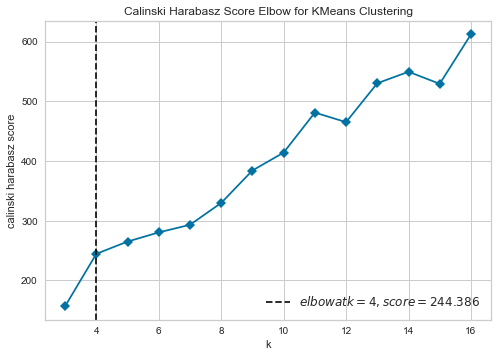

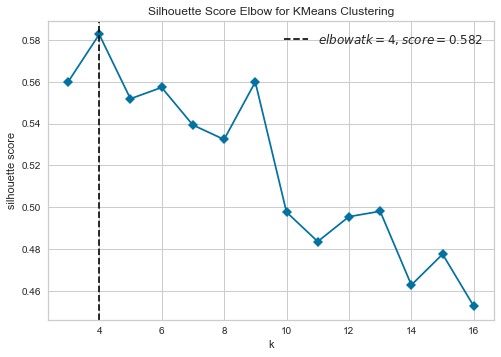

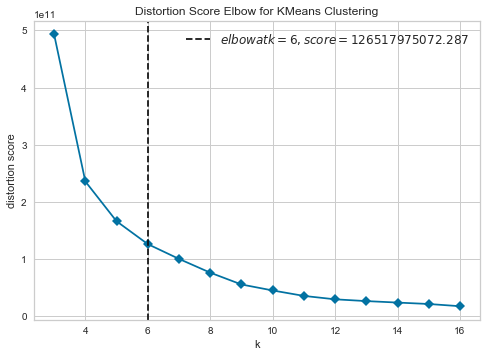

In [368]:
cluster3= new_clustering_pca[new_clustering_pca['Cluster']==2].copy()
cluster3.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(cluster3, model)

In [369]:
kmeans_cluster3 = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_cluster3.fit(cluster3)
results_evaluation_subclusters(kmeans_cluster3, cluster3, 2)

CLUSTERING DIVISION:
 3    36
0    27
2    11
4     8
1     2
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,208562.23,26757.07,181.02
1,926181.54,68660.72,213.49
2,314735.42,20131.14,105.40
3,114925.55,13714.71,78.43
4,517021.34,84374.76,282.73


The Silhouette Score is:  0.551802975256314
The Calinski Harabasz Score is:  264.9363459897275
The Davies Douldin Score is:  0.5756006346880609


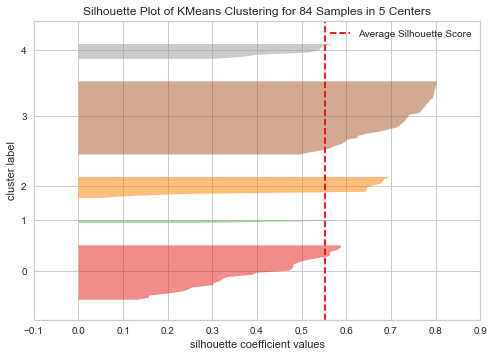

In [370]:
sv = SilhouetteVisualizer(kmeans_cluster3)
sv.fit(cluster3)
sv.show()

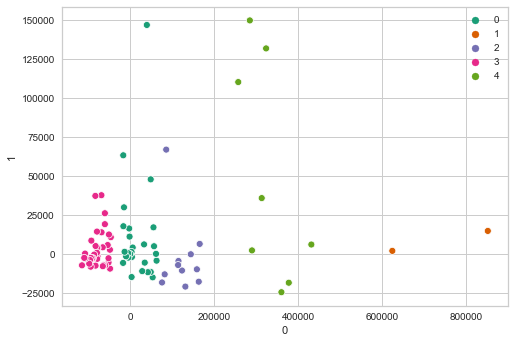

In [371]:
sns.scatterplot(cluster3[0], cluster3[1], hue=kmeans_cluster3.labels_,palette='Dark2')

In [385]:
subclusters3 = subclustering[subclustering['Cluster']==2].copy()
subclusters3['Subcluster'] = kmeans_cluster3.labels_
subclusters3.drop('Cluster', 1).groupby('Subcluster').describe()

Format Loads                                                    \
                  count      mean       std       min       25%       50%   
Subcluster                                                                  
0                 27.00 208562.23  28356.70 171119.13 186848.75 195708.43   
1                  2.00 926181.54 159660.38 813284.60 869733.07 926181.54   
2                 11.00 314735.42  32932.94 268079.62 289810.62 314975.38   
3                 36.00 114925.55  19032.53  77507.82 100775.66 112890.95   
4                  8.00 517021.34  59470.47 441098.08 476736.20 503586.53   

                                Impressions                             \
                 75%        max       count     mean      std      min   
Subcluster                                                               
0          235643.92  254259.64       27.00 26757.07 32677.01   648.87   
1          982630.01 1039078.48        2.00 68660.72 18842.46 55337.09   
2          342774.52  355945.39       11.00 20131.14 23994.34  1590.34   
3          129860.71  144723.54       36.00 13714.71 12142.01   926.65   
4          556021.48  620897.83        8.00 84374.76 68400.77 12734.44   

                                                 Clicks                      \
                25%      50%       75%       max  count   mean    std   min   
Subcluster                                                                    
0          12174.02 15781.19  28787.38 164143.81  27.00 181.02 197.43  4.12   
1          61998.90 68660.72  75322.53  81984.35   2.00 213.49 288.65  9.39   
2           7313.41 15090.54  20788.34  87213.09  11.00 105.40  84.42  0.13   
3           5774.81  9089.35  17746.75  48605.18  36.00  78.43  68.00  5.61   
4          31373.43 58849.88 147314.93 182056.45   8.00 282.73 197.89 32.83   

                                        
              25%    50%    75%    max  
Subcluster                              
0           77.06 120.15 205.43 897.36  
1          111.44 213.49 315.55 417.60  
2           52.13  89.12 146.21 275.59  
3           26.16  62.95 106.67 305.21  
4          157.16 270.75 380.49 642.84

- Cluster 3 subgroup 1:
- Cluster 3 subgroup 2:
- Cluster 3 subgroup 3:
- Cluster 3 subgroup 4:
- Cluster 3 subgroup 5:


### SUBCLUSTERING: CLUSTER 4

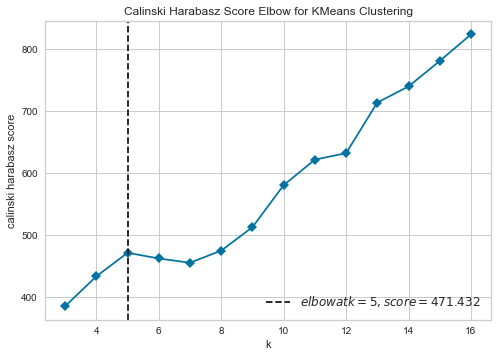

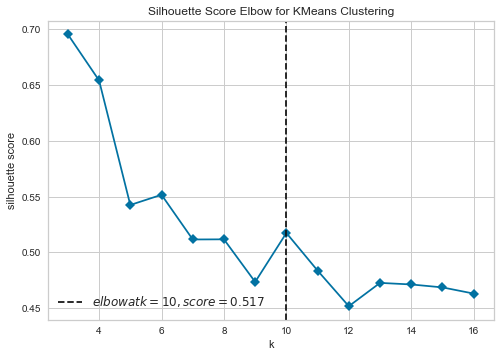

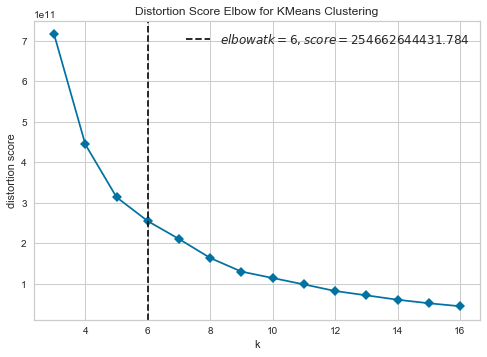

In [373]:
cluster4= new_clustering_pca[new_clustering_pca['Cluster']==3].copy()
cluster4.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(cluster4, model)

CLUSTERING DIVISION:
 4    58
0    27
3    17
5    11
1     8
2     4
6     1
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,202568.64,13368.99,112.54
1,620362.02,31201.91,291.53
2,895886.99,171765.29,1535.62
3,413181.96,47083.46,298.96
4,130983.33,14126.25,102.11
5,293181.46,27712.64,157.91
6,1133190.34,83338.45,754.09


The Silhouette Score is:  0.5111592394688365
The Calinski Harabasz Score is:  474.19747892319606
The Davies Douldin Score is:  0.5617164247853953


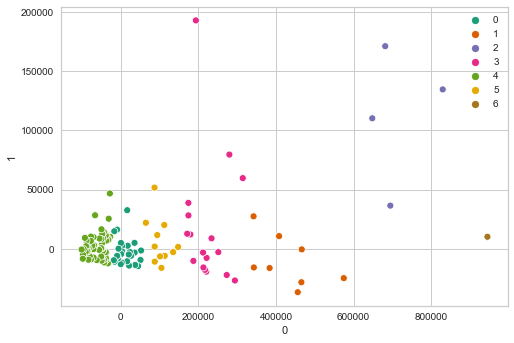

In [383]:
kmeans_cluster4 = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_cluster4.fit(cluster4)
results_evaluation_subclusters(kmeans_cluster4, cluster4, 3)
sns.scatterplot(cluster4[0], cluster4[1], hue=kmeans_cluster4.labels_,palette='Dark2')

In [386]:
subclusters4 = subclustering[subclustering['Cluster']==3].copy()
subclusters4['Subcluster'] = kmeans_cluster4.labels_
subclusters4.drop('Cluster', 1).groupby('Subcluster').describe()

Format Loads                                                       \
                  count       mean      std        min        25%        50%   
Subcluster                                                                     
0                 27.00  202568.64 21252.40  173066.21  184579.92  194149.87   
1                  8.00  620362.02 78131.81  530497.56  564304.94  622606.53   
2                  4.00  895886.99 79223.77  830853.57  853025.41  871084.60   
3                 17.00  413181.96 44851.28  360690.26  371914.32  408205.95   
4                 58.00  130983.33 21149.57   89886.76  113110.73  140095.45   
5                 11.00  293181.46 23871.46  253794.84  278125.78  291976.52   
6                  1.00 1133190.34      nan 1133190.34 1133190.34 1133190.34   

                                 Impressions                              \
                  75%        max       count      mean      std      min   
Subcluster                                                                 
0           215788.09  242870.53       27.00  13368.99 10518.88  2394.07   
1           656383.06  765736.84        8.00  31201.91 19437.36  6729.94   
2           913946.19 1010525.20        4.00 171765.29 57716.11 94230.07   
3           441729.17  500735.81       17.00  47083.46 53640.39  6680.58   
4           147262.82  162818.65       58.00  14126.25 11082.23   999.17   
5           302689.68  338016.48       11.00  27712.64 18879.36  5724.44   
6          1133190.34 1133190.34        1.00  83338.45      nan 83338.45   

                                                   Clicks                  \
                 25%       50%       75%       max  count    mean     std   
Subcluster                                                                  
0            5223.64  11165.28  17634.84  48860.60  27.00  112.54   80.98   
1           19400.44  24253.80  45316.57  63617.31   8.00  291.53  311.56   
2          147229.47 182608.21 207144.03 227614.64   4.00 1535.62 1418.72   
3           12668.54  27925.40  54138.22 219450.27  17.00  298.96  369.32   
4            5406.43  11765.67  20842.75  60204.25  58.00  102.11  105.53   
5           15758.70  22575.30  36953.54  72224.61  11.00  157.91  102.75   
6           83338.45  83338.45  83338.45  83338.45   1.00  754.09     nan   

                                                  
              min    25%     50%     75%     max  
Subcluster                                        
0           14.75  44.31   98.10  176.24  284.60  
1            4.01  81.36  190.85  406.36  954.12  
2          369.24 680.30 1106.21 1961.53 3560.82  
3           55.08 137.80  213.17  325.75 1638.63  
4            6.48  28.78   76.14  131.19  499.94  
5           24.21 121.62  131.90  188.03  383.73  
6          754.09 754.09  754.09  754.09  754.09

- Cluster 4 subgroup 1:
- Cluster 4 subgroup 2:
- Cluster 4 subgroup 3:
- Cluster 4 subgroup 4:
- Cluster 4 subgroup 5:
- Cluster 4 subgroup 6:
- Cluster 4 subgroup 7:

In [391]:
subclusters1.to_csv('Subclusters1.csv')
subclusters2.to_csv('Subclusters2.csv')
subclusters3.to_csv('Subclusters3.csv')
subclusters4.to_csv('Subclusters4.csv')

- Taking a quick look, we can see that the dense clusters are the ones with few Format Loads, compared with the rest of clusters

## IDEAS:

- Drop the domains with less than 10% of recurrence

- This can be a general and internal analysis for the company, with the 818 domains so they can filter and see which ones have a low quality

- The analysis for the adertisers can be done selecting only those domains with a minimum standard of quality, and repeating this clustering proccess with the filtered domains

- Include AIC y BIC scores
